## Introduction

This notebook analyzes the ego-facebook network. It is an undirected, unweighted network that contains Facebook user–user friendships. A node represents a user. An edge indicates that the user represented by the left node is a friend of the user represented by the right node. The dataset can be donloaded from [snap.standford.edu](https://snap.stanford.edu/data/ego-Facebook.html). 

In [ ]:
# !pip install ndlib
# !pip install matplotlib

In [3]:
%matplotlib inline
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import copy
import random

import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import ndlib.models.opinions as op
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from ndlib.models.DiffusionModel import DiffusionModel
from ndlib.models.ModelConfig import Configuration
from statistics import mean

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from typing import List
from networkx.classes.graph import Graph
from functools import reduce
from random import choice

## uncomment to test
# from matplotlib.font_manager import findfont, FontProperties
# font = findfont(FontProperties(family=['sans-serif']))
# nx.draw(nx.barabasi_albert_graph(10, 2))

### Loading graphs

We will begin with plotting the graph and visualize basic information.

In [4]:
# df_edges = pd.read_csv("data/ego-facebook/out.csv", sep=" ")
df_edges = pd.read_csv("data/facebook_combined.txt", sep=" ")
g_fb = nx.from_pandas_edgelist(df_edges, source="SOURCE", target="TARGET")

print("Number of vertices: {}".format(g_fb.number_of_nodes()))
print("Number of edges: {}".format(g_fb.number_of_edges()))

Number of vertices: 4039
Number of edges: 88234


Here we will define some useful functions for analyzing and comparing graph metrics.
The main analysis function creates plots for:
- connected components of graph
- degree rankings
- degree histogram



In [5]:
def do_analysis(G: Graph):
   degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
   dmax = max(degree_sequence)

   fig = plt.figure("Degree of a random graph", figsize=(8, 8))
   # Create a gridspec for adding subplots of different sizes
   axgrid = fig.add_gridspec(5, 4)

   ax0 = fig.add_subplot(axgrid[0:3, :])
   Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
   pos = nx.spring_layout(Gcc, seed=10396953)
   nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
   nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
   ax0.set_title("Connected components of G")
   ax0.set_axis_off()

   ax1 = fig.add_subplot(axgrid[3:, :2])
   ax1.plot(degree_sequence, "b-", marker="o")
   ax1.set_title("Degree Rank Plot")
   ax1.set_ylabel("Degree")
   ax1.set_xlabel("Rank")

   ax2 = fig.add_subplot(axgrid[3:, 2:])
   ax2.bar(*np.unique(degree_sequence, return_counts=True))
   ax2.set_title("Degree histogram")
   ax2.set_xlabel("Degree")
   ax2.set_ylabel("# of Nodes")

   fig.tight_layout()
   plt.show()

def get_triangles_count(G: Graph):
   return sum(nx.triangles(G).values())/3;


def get_graph_degrees(G: Graph):
   edges_per_node = {};
   for node in G.nodes:
      count = 0;
      for edge in G.edges(node):
         count += 1;
      edges_per_node[node] = count;
      # print("Node {} has {} edges".format(node, count))
   return edges_per_node


def str_batch(msg: str, size=27, whitespace=" "):
   spaces = size - len(msg)
   result = msg
   for i in range(spaces):
      result = result + whitespace
   return result


def print_min_max(metrics: dict, label: str, n: int=10):
  sorted_list = list(dict(sorted(metrics.items(), key=lambda item: item[1], reverse=True)).items())
  print("Top max:")
  for e in sorted_list[:n]:
    print("{} of {} is {}".format(label, e[0], e[1]))

  sorted_list = list(dict(sorted(metrics.items(), key=lambda item: item[1], reverse=False)).items())
  print("Top min:")
  for e in sorted_list[:n]:
    print("{} of {} is {}".format(label, e[0], e[1]))


def do_comparison(graphs: List[Graph], graphnames: List[str]=[]):
   names = {
      'num_vertices': "Number of vertices",
      'num_edges': "Number of edges",
      'max_degree': "Max vertex degree",
      'avg_degree': "Avg vertex degree",
      'avg_closeness_centrality': "Avg closeness centrality",
      'avg_degree_centrality':"Avg degree centrality",
      'radius': "Radius",
      'diameter': "Diameter",
      'avg_clust_coef': "Avg clustering coefficient",
      'num_triangles': "Number of triangles",
      'transitivity': "Transitivity",
      'density': "Density"
   }
   res = {
      'num_vertices': [],
      'num_edges': [],
      'max_degree': [],
      'avg_degree': [],
      'avg_closeness_centrality': [],
      'avg_degree_centrality': [],
      'radius': [],
      'diameter': [],
      'avg_clust_coef': [],
      'num_triangles': [],
      'transitivity': [],
      'density': []
   }
   for g in graphs:
      degrees = get_graph_degrees(g)
      max_degree = max(degrees.values())
      avg_degree = reduce(lambda a, b: a + b, degrees.values()) / len(degrees)
      closeness_cntr = nx.closeness_centrality(g);
      avg_closeness_cntr = reduce(lambda a, b: a + b, closeness_cntr.values()) / len(closeness_cntr)
      degree_cntr = nx.degree_centrality(g);
      avg_degree_cntr = reduce(lambda a, b: a + b, degree_cntr.values()) / len(degree_cntr)

      res['num_vertices'].append(g.number_of_nodes())
      res['num_edges'].append(g.number_of_edges())
      res['max_degree'].append(max_degree)
      res['avg_degree'].append(avg_degree)
      res['avg_closeness_centrality'].append(avg_closeness_cntr)
      res['avg_degree_centrality'].append(avg_degree_cntr)
      res['radius'].append(nx.radius(g))
      res['diameter'].append(nx.diameter(g))
      res['avg_clust_coef'].append(nx.average_clustering(g))
      res['num_triangles'].append(get_triangles_count(g))
      res['transitivity'].append(nx.transitivity(g))
      res['density'].append(nx.density(g))

   # print labels
   label = str_batch("METRICS")
   i=0
   for g in graphs:
      label += str_batch(graphnames[i] if graphnames else "Graph #" + str(i))
      i += 1
   print(label)
   
   # print separator
   separator = str_batch("", whitespace="-")
   for g in graphs:
      separator += str_batch("", whitespace="-")
   print(separator)

   # print metrics
   for key in res:
      line = str_batch(names[key])
      
      for v in res[key]:
         line = line + str_batch(str(v))
      print(line)


def plot_histogram(G: Graph, n: int=1000):
  hist = nx.degree_histogram(G)
  plt.xlabel("Degree")
  plt.ylabel("# of Nodes")
  plt.plot(range(n), hist[:n]);

METRICS                    Graph #0                   
------------------------------------------------------
Number of vertices         4039                       
Number of edges            88234                      
Max vertex degree          1045                       
Avg vertex degree          43.69101262688784          
Avg closeness centrality   0.2761677635668379         
Avg degree centrality      0.010819963503439833       
Radius                     4                          
Diameter                   8                          
Avg clustering coefficient 0.6055467186200876         
Number of triangles        1612010.0                  
Transitivity               0.5191742775433075         
Density                    0.010819963503439287       


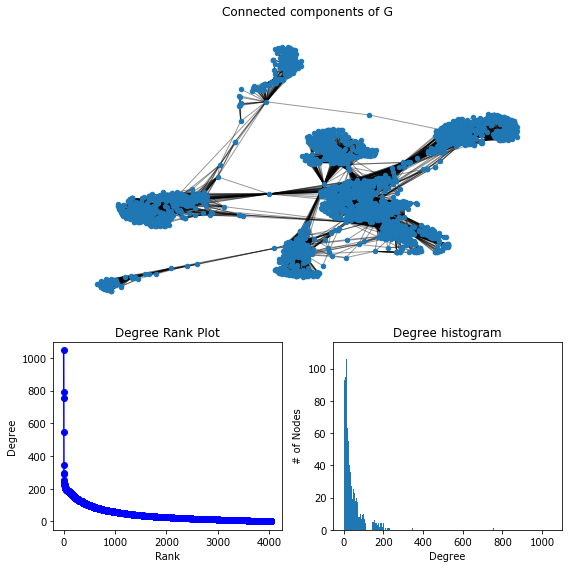

In [6]:
do_comparison([g_fb])
do_analysis(g_fb)

#### Extracting Ego Graph

Due to the high amount of information this graph contains, we select to extract an ego-graph to improve the performance of processing the graph.  

By getting the vertex degree of the graph and sorting, we get that the nodes with the highest degree are the following:

| Node | Degree |
|------|--------|
| 107  | 1045   |
| 1684 | 792    |
| 1912 | 755    |
| 3437 | 547    |
| 0    | 347    |
| ...  | ...    |
| 37   | 1      |
| 18   | 1      |
| 15   | 1      |
| 12   | 1      |
| 11   | 1      |

After analyzing many of them, we selected the node `15` as our center because the ego-graph centered on this node would give us a good amount of nodes with radius > 1.

In [7]:
## getting a subgraph
g_degree = {};
for node in g_fb.nodes:
   count = 0;
   for edge in g_fb.edges(node):
      count += 1;
   g_degree[node] = count;

print_min_max(get_graph_degrees(g_fb), "Vertex Degree", 5)


Top max:
Vertex Degree of 107 is 1045
Vertex Degree of 1684 is 792
Vertex Degree of 1912 is 755
Vertex Degree of 3437 is 547
Vertex Degree of 0 is 347
Top min:
Vertex Degree of 11 is 1
Vertex Degree of 12 is 1
Vertex Degree of 15 is 1
Vertex Degree of 18 is 1
Vertex Degree of 37 is 1


Number of vertices: 1519
Number of edges: 33690


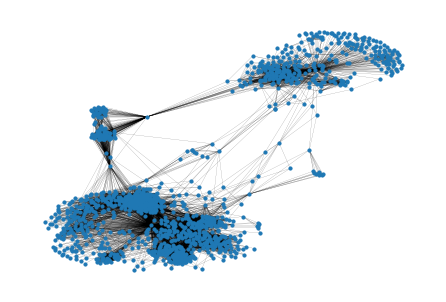

In [8]:
G = nx.ego_graph(g_fb, 15, radius=3)
print("Number of vertices: {}".format(G.number_of_nodes()))
print("Number of edges: {}".format(G.number_of_edges()))
nx.draw(G, node_size=10, width=0.1)

### Basic Measures

In [9]:
print("Number of vertices: {}".format(G.number_of_nodes()))
print("Number of edges: {}".format(G.number_of_edges()))

Number of vertices: 1519
Number of edges: 33690


### Degree Measures

In [10]:
print_min_max(get_graph_degrees(G), "Vertex Degree")

Top max:
Vertex Degree of 107 is 1045
Vertex Degree of 0 is 347
Vertex Degree of 1888 is 254
Vertex Degree of 1800 is 245
Vertex Degree of 1663 is 235
Vertex Degree of 1352 is 234
Vertex Degree of 1730 is 226
Vertex Degree of 1431 is 220
Vertex Degree of 1199 is 217
Vertex Degree of 1584 is 211
Top min:
Vertex Degree of 11 is 1
Vertex Degree of 12 is 1
Vertex Degree of 15 is 1
Vertex Degree of 18 is 1
Vertex Degree of 37 is 1
Vertex Degree of 43 is 1
Vertex Degree of 74 is 1
Vertex Degree of 114 is 1
Vertex Degree of 209 is 1
Vertex Degree of 210 is 1


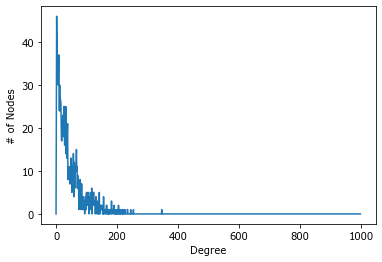

In [17]:
plot_histogram(G);

### Distance Metrics

In [18]:
## WARNING: slow (~30s but slower for many edges)
shortest_paths = {}
for source in G.nodes:
   for target in G.nodes:
      path_key = [source, target]
      path_key.sort()
      key = tuple(path_key)
      if source != target and key not in shortest_paths:
         shortest_paths[key] = nx.shortest_path(G, source, target)

In [19]:
short_shortest_paths = list(dict(sorted(shortest_paths.items(), key=lambda item: len(item[1]), reverse=False)).items())
long_shortest_paths = list(dict(sorted(shortest_paths.items(), key=lambda item: len(item[1]), reverse=True)).items())

print("Top 10 shortest paths:")
for p in short_shortest_paths[:10]:
   print("From {} to {} -> {} ({})".format(p[0][0], p[0][1], len(p[1]), p[1]))
   
print("-------------------------------------------------------------------")

print("Top 10 longest paths:")
for p in long_shortest_paths[:10]:
   print("From {} to {} -> {} ({})".format(p[0][0], p[0][1], len(p[1]), p[1]))

Top 10 shortest paths:
From 0 to 1 -> 2 ([0, 1])
From 0 to 2 -> 2 ([0, 2])
From 0 to 3 -> 2 ([0, 3])
From 0 to 4 -> 2 ([0, 4])
From 0 to 5 -> 2 ([0, 5])
From 0 to 6 -> 2 ([0, 6])
From 0 to 7 -> 2 ([0, 7])
From 0 to 8 -> 2 ([0, 8])
From 0 to 9 -> 2 ([0, 9])
From 0 to 10 -> 2 ([0, 10])
-------------------------------------------------------------------
Top 10 longest paths:
From 351 to 1926 -> 5 ([351, 198, 0, 136, 1926])
From 351 to 1932 -> 5 ([351, 198, 0, 136, 1932])
From 351 to 1939 -> 5 ([351, 198, 0, 136, 1939])
From 351 to 1945 -> 5 ([351, 198, 0, 136, 1945])
From 351 to 1951 -> 5 ([351, 198, 0, 136, 1951])
From 351 to 1955 -> 5 ([351, 198, 0, 136, 1955])
From 351 to 1972 -> 5 ([351, 198, 0, 136, 1972])
From 351 to 1973 -> 5 ([351, 198, 0, 136, 1973])
From 351 to 1976 -> 5 ([351, 198, 0, 136, 1976])
From 351 to 1991 -> 5 ([351, 198, 0, 136, 1991])


In [20]:
distance_matrix = {};
for node in G.nodes:
   distance_matrix[node] = nx.single_source_shortest_path_length(G, node)

pd_distance_matrix = pd.DataFrame.from_dict(distance_matrix)

## Rows: target
## Columns: source
# pd_distance_matrix

In [21]:
## Eccentricity -> max distance from source to every other targets
ec = nx.eccentricity(G)

print_min_max(ec, "Eccentricity")
sorted_ec = list(dict(sorted(ec.items(), key=lambda item: item[1], reverse=True)).items())

# print("-------------------------------------------------------------------")
# for node in G:
#    print("Eccentricity of node {} is {}".format(node, ec[node]))

Top max:
Eccentricity of 351 is 4
Eccentricity of 363 is 4
Eccentricity of 364 is 4
Eccentricity of 389 is 4
Eccentricity of 393 is 4
Eccentricity of 399 is 4
Eccentricity of 427 is 4
Eccentricity of 441 is 4
Eccentricity of 464 is 4
Eccentricity of 476 is 4
Top min:
Eccentricity of 0 is 2
Eccentricity of 1 is 3
Eccentricity of 2 is 3
Eccentricity of 3 is 3
Eccentricity of 4 is 3
Eccentricity of 5 is 3
Eccentricity of 6 is 3
Eccentricity of 7 is 3
Eccentricity of 8 is 3
Eccentricity of 9 is 3


In [23]:
## Radius -> Minimum eccentricity of all the vertices in the graph
print("Radius: {}".format(nx.radius(G)))
## Diameter -> Maximum eccentricity of all the vertices in the graph or greatest distance between any pair of vertices in the graph
print("Diameter: {}".format(nx.diameter(G)))

Radius: 2
Diameter: 4


### Centralities

#### Closeness Centrality

In [24]:
cc = nx.closeness_centrality(G)
print_min_max(cc, "Closeness Centrality", 10)
   
# for node in G:
#   print("Closeness Centrality of node {} is {}".format(node, cc[node]))

Top max:
Closeness Centrality of 107 is 0.75
Closeness Centrality of 0 is 0.5645221271848271
Closeness Centrality of 58 is 0.500164744645799
Closeness Centrality of 171 is 0.4843650287172942
Closeness Centrality of 1663 is 0.4726027397260274
Closeness Centrality of 1352 is 0.47245564892623715
Closeness Centrality of 1126 is 0.46722068328716526
Closeness Centrality of 1621 is 0.46593001841620624
Closeness Centrality of 1376 is 0.4649310872894334
Closeness Centrality of 1835 is 0.4649310872894334
Top min:
Closeness Centrality of 2635 is 0.28400374181478016
Closeness Centrality of 2571 is 0.2842164388691256
Closeness Centrality of 2225 is 0.2843761708505058
Closeness Centrality of 2636 is 0.28448275862068967
Closeness Centrality of 2660 is 0.28448275862068967
Closeness Centrality of 2494 is 0.2845360824742268
Closeness Centrality of 1976 is 0.2845894263217098
Closeness Centrality of 2337 is 0.2845894263217098
Closeness Centrality of 2647 is 0.2845894263217098
Closeness Centrality of 1991 

#### Betweenness Centrality

In [25]:
bc = nx.betweenness_centrality(G)
print_min_max(bc, "Betweenness Centrality")

# for node in G:
#   print("Betweeness Centrality of node {} is {}".format(node, bc[node]))

Top max:
Betweenness Centrality of 107 is 0.7559580078905895
Betweenness Centrality of 0 is 0.3763614495653673
Betweenness Centrality of 1718 is 0.04213359686539239
Betweenness Centrality of 136 is 0.03958578438427249
Betweenness Centrality of 1577 is 0.030567240788486556
Betweenness Centrality of 1912 is 0.019122207497291897
Betweenness Centrality of 1465 is 0.016974466725539497
Betweenness Centrality of 348 is 0.010363872351506598
Betweenness Centrality of 171 is 0.006929412293871833
Betweenness Centrality of 58 is 0.006133720246082696
Top min:
Betweenness Centrality of 11 is 0.0
Betweenness Centrality of 12 is 0.0
Betweenness Centrality of 15 is 0.0
Betweenness Centrality of 18 is 0.0
Betweenness Centrality of 32 is 0.0
Betweenness Centrality of 33 is 0.0
Betweenness Centrality of 35 is 0.0
Betweenness Centrality of 37 is 0.0
Betweenness Centrality of 42 is 0.0
Betweenness Centrality of 43 is 0.0


#### Degree Centrality

In [26]:
## the number of links incident upon a node 
dc = nx.degree_centrality(G)
print_min_max(dc, "Degree Centrality")

# for node in G:
#   print("Degree Centrality of node {} is {}".format(node, dc[node]))

Top max:
Degree Centrality of 107 is 0.6884057971014493
Degree Centrality of 0 is 0.22859025032938077
Degree Centrality of 1888 is 0.1673254281949934
Degree Centrality of 1800 is 0.1613965744400527
Degree Centrality of 1663 is 0.15480895915678525
Degree Centrality of 1352 is 0.1541501976284585
Degree Centrality of 1730 is 0.14888010540184454
Degree Centrality of 1431 is 0.14492753623188406
Degree Centrality of 1199 is 0.14295125164690384
Degree Centrality of 1584 is 0.13899868247694336
Top min:
Degree Centrality of 11 is 0.0006587615283267457
Degree Centrality of 12 is 0.0006587615283267457
Degree Centrality of 15 is 0.0006587615283267457
Degree Centrality of 18 is 0.0006587615283267457
Degree Centrality of 37 is 0.0006587615283267457
Degree Centrality of 43 is 0.0006587615283267457
Degree Centrality of 74 is 0.0006587615283267457
Degree Centrality of 114 is 0.0006587615283267457
Degree Centrality of 209 is 0.0006587615283267457
Degree Centrality of 210 is 0.0006587615283267457


#### Eigenvector Centrality

Relative scores are assigned to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes. A high eigenvector score means that a node is connected to many nodes who themselves have high scores.

Variants: PageRank, Katz

In [41]:
evc = nx.eigenvector_centrality(G, 200)
print_min_max(evc, "Eigenvector Centrality")

# for node in G:
#   print("Eigenvector Centrality of node {} is {}".format(node, evc[node]))

Top max:
Eigenvector Centrality of 107 is 0.13796627730289923
Eigenvector Centrality of 1888 is 0.11454417259502485
Eigenvector Centrality of 1800 is 0.11042749172566355
Eigenvector Centrality of 1663 is 0.10766694909468896
Eigenvector Centrality of 1352 is 0.10667699531954421
Eigenvector Centrality of 1431 is 0.10296500373619671
Eigenvector Centrality of 1199 is 0.10286259887491238
Eigenvector Centrality of 1730 is 0.10086413257777135
Eigenvector Centrality of 1589 is 0.10013773711278447
Eigenvector Centrality of 1746 is 0.09790508039668779
Top min:
Eigenvector Centrality of 2494 is 6.3940980943631615e-06
Eigenvector Centrality of 2636 is 6.413187361128276e-06
Eigenvector Centrality of 2647 is 6.500293006489702e-06
Eigenvector Centrality of 2337 is 6.65118853495213e-06
Eigenvector Centrality of 1991 is 6.729447565806138e-06
Eigenvector Centrality of 2284 is 6.784536221228347e-06
Eigenvector Centrality of 2225 is 6.915328095847243e-06
Eigenvector Centrality of 1951 is 7.121065077935503

#### Katz Centrality

In [ ]:
## generalization of eigenvector centrality
##TODO not working yet, running forever
# kc = nx.katz_centrality(G, max_iter=1_000_000)
# print_min_max(kc, "Katz Centrality")

# for node in G:
#   print("Katz Centrality of node {} is {}".format(node, kc[node]))

#### Edge Betweenness Centrality

In [43]:
## the number of the shortest paths that go through an edge
ebc = nx.edge_betweenness_centrality(G)
print_min_max(ebc, "Edge Betweenness Centrality")

# for edge in G:
#   print("Edge Betweeness Centrality of edge {} is {}".format(edge, ebc[edge]))

Top max:
Edge Betweenness Centrality of (0, 107) is 0.3056209167308995
Edge Betweenness Centrality of (107, 1577) is 0.026518802934129244
Edge Betweenness Centrality of (0, 136) is 0.02329684164277813
Edge Betweenness Centrality of (107, 1718) is 0.021356563459242636
Edge Betweenness Centrality of (107, 1465) is 0.015308326806991165
Edge Betweenness Centrality of (107, 348) is 0.009099355037920566
Edge Betweenness Centrality of (428, 1912) is 0.0051247627854581704
Edge Betweenness Centrality of (107, 171) is 0.005003407892169158
Edge Betweenness Centrality of (136, 1718) is 0.004884512645535612
Edge Betweenness Centrality of (58, 107) is 0.004876600183067945
Top min:
Edge Betweenness Centrality of (4, 181) is 8.673621176125685e-07
Edge Betweenness Centrality of (4, 275) is 8.673621176125685e-07
Edge Betweenness Centrality of (6, 147) is 8.673621176125685e-07
Edge Betweenness Centrality of (8, 91) is 8.673621176125685e-07
Edge Betweenness Centrality of (8, 259) is 8.673621176125685e-07


### Clustering Coefficients

In [44]:
## Clustering Coefficients
##
## Local: how close its neighbours are to being a clique (complete graph) 
## Global: (number of closed triplets) / (number of all triplets)
##         average of all local coefficients
## Average: alternative to the global clustering coefficient

print("Average clustering coefficient: {}".format(nx.average_clustering(G)))

clustering = nx.clustering(G)

min_val = min(clustering.values());
max_val = max(clustering.values());
min_count = 0;
max_count = 0;
for c in clustering.items():
   if c[1] == 0: min_count += 1;
   if c[1] == 1.0: max_count += 1;
print("Min clustering coefficient = {}, found in {} nodes".format(min_val, min_count))
print("Max clustering coefficient = {}, found in {} nodes".format(max_val, max_count))

# print("-------------------------------------------------------------------")
# for node in G.nodes:
#    print("Clustering coefficient for node {} is {}".format(node, clustering[node]))

Average clustering coefficient: 0.6120218194434013
Min clustering coefficient = 0, found in 25 nodes
Max clustering coefficient = 1.0, found in 110 nodes


### Triangle Counts and Closed Triangles

In [46]:
print("Number of triangles: {}".format(get_triangles_count(G)))

## Transitivity
## - fraction of all possible triangles present in G (divided by the number of "triads")
## - the overall probability for the network to have adjacent nodes interconnected, thus revealing the existence of tightly connected communities (or clusters, subgroups, cliques)
print("Graph transitivity: {}".format(nx.transitivity(G)))

Number of triangles: 504947.0
Graph transitivity: 0.44279095734730145


### Homophily and Similarity

Since we do not have an extra column in our dataset we can not determine as far as homophily of nodes concerned. Practically we do not have something in common for the nodes except for the edges. So we stay with similarity metric of the graph and its complement.

In [33]:
def get_cn_similarity(G: Graph, common_neighbors):
    cn_similarity = {}
    for u, v in G.edges:
        common_neighbors[u, v]=list(nx.common_neighbors(G, u, v))
        cn_similarity[u, v]=len(common_neighbors[u, v])
    return cn_similarity

In [45]:
common_neighbors = {}
cn_similarity = get_cn_similarity(G, common_neighbors)

print_min_max(cn_similarity, "Similarity")

Top max:
Similarity of (107, 1888) is 253
Similarity of (107, 1800) is 244
Similarity of (107, 1663) is 234
Similarity of (107, 1352) is 233
Similarity of (107, 1730) is 225
Similarity of (107, 1431) is 219
Similarity of (107, 1199) is 216
Similarity of (1800, 1888) is 212
Similarity of (107, 1584) is 210
Similarity of (107, 1768) is 208
Top min:
Similarity of (0, 11) is 0
Similarity of (0, 12) is 0
Similarity of (0, 15) is 0
Similarity of (0, 18) is 0
Similarity of (0, 37) is 0
Similarity of (0, 43) is 0
Similarity of (0, 74) is 0
Similarity of (0, 114) is 0
Similarity of (0, 209) is 0
Similarity of (0, 210) is 0


In [13]:
G_complement = nx.complement(G)

In [49]:
## WARNING: slow (~2m30s for G(1500, 33600))
non_edge_cn_similarity = {}
for u, v in G_complement.edges:
    non_edge_cn_similarity[u, v] = len(list(nx.common_neighbors(G, u, v)))

print_min_max(non_edge_cn_similarity, "Complement's Similarity")

Top max:
Complement's Similarity of (1431, 1707) is 156
Complement's Similarity of (1078, 1610) is 136
Complement's Similarity of (1610, 1714) is 135
Complement's Similarity of (1584, 1610) is 133
Complement's Similarity of (1078, 1827) is 132
Complement's Similarity of (1086, 1584) is 131
Complement's Similarity of (1390, 1559) is 130
Complement's Similarity of (1559, 1707) is 129
Complement's Similarity of (1078, 1613) is 126
Complement's Similarity of (1391, 1804) is 125
Top min:
Complement's Similarity of (1, 348) is 0
Complement's Similarity of (1, 351) is 0
Complement's Similarity of (1, 353) is 0
Complement's Similarity of (1, 363) is 0
Complement's Similarity of (1, 364) is 0
Complement's Similarity of (1, 366) is 0
Complement's Similarity of (1, 376) is 0
Complement's Similarity of (1, 389) is 0
Complement's Similarity of (1, 393) is 0
Complement's Similarity of (1, 399) is 0


Max similarity=253


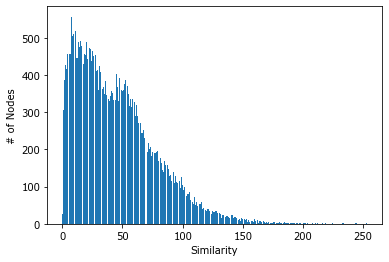

In [199]:
plt.ylabel("# of Nodes")
plt.xlabel("Similarity")
plt.hist(cn_similarity.values(), 300);
print("Max similarity={}".format(max(cn_similarity.values())))

Max complement's similarity=156


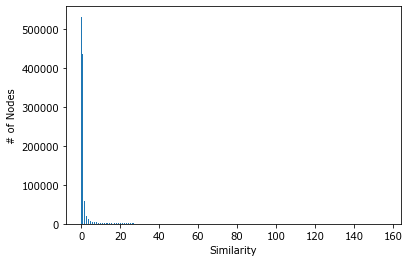

In [200]:
plt.ylabel("# of Nodes")
plt.xlabel("Similarity")
plt.hist(non_edge_cn_similarity.values(), 300);
print("Max complement's similarity={}".format(max(non_edge_cn_similarity.values())))

## Statistical Analysis

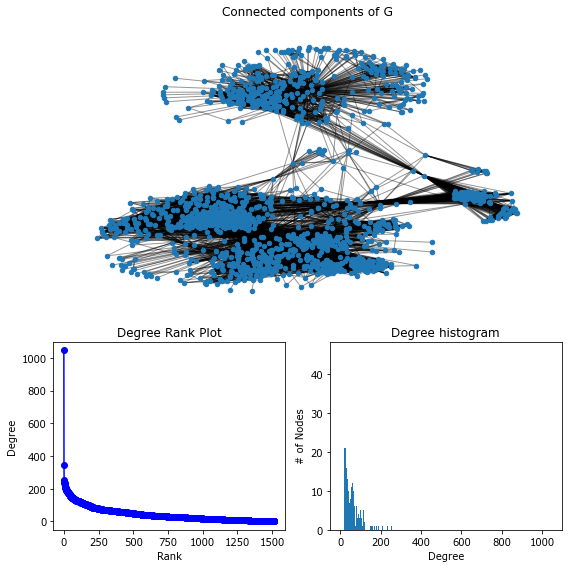

In [121]:
do_analysis(G)

In [122]:
## this is not very useful
main_num_nodes = g_fb.number_of_nodes()
main_num_edges = g_fb.number_of_edges()
sub_num_nodes = G.number_of_nodes()
sub_num_edges = G.number_of_edges()

print("Number of vertices: {} ({:.2f}% of total vetrices)".format(sub_num_nodes, (sub_num_nodes/main_num_nodes)*100))
print("Number of edges: {} ({:.2f}% of total edges)".format(sub_num_edges, (sub_num_edges/main_num_edges)*100))

Number of vertices: 1519 (37.61% of total vetrices)
Number of edges: 33690 (38.18% of total edges)


In [123]:
## density = 2n / m(m-1)
## n -> number of nodes
## m -> number of edges
## notes: density is 0 for a graph without edges and 1 for a complete graph

print("Graph's density: {}".format(nx.density(G)))

Graph's density: 0.02922142974236743


## Graph Generation

The following scenarios are being compared:

**Scenario A**: Basic generators  
Graphs generated based on Erdos-Renyi, Wattz-Strogatz and power-law cluster.  

**Scenario B**: Advanced generators  
Graphs generated using the Barabasi Albert approach.  
Graph #1 is a simple invocation of Barabasi Albert graph generator.  
Graph #2 uses as initial graph a star graph and extends it with the Barabasi Albert generator.  
Graph #3 is similar, using as base graph a windmill graph.  

**Scenario C**: Custom generator  
A graph generated using a complex combination of other simple base graphs.

METRICS                    ego-facebook               
------------------------------------------------------
Number of vertices         1519                       
Number of edges            33690                      
Max vertex degree          1045                       
Avg vertex degree          44.35813034891376          
Avg closeness centrality   0.4110420684456024         
Avg degree centrality      0.029221429742367442       
Radius                     2                          
Diameter                   4                          
Avg clustering coefficient 0.6120218194434013         
Number of triangles        504947.0                   
Transitivity               0.44279095734730145        
Density                    0.02922142974236743        


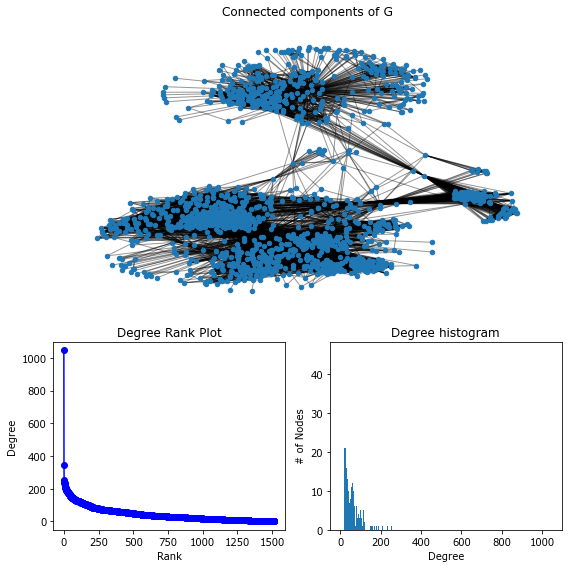

In [27]:
do_comparison([G], ["ego-facebook"])
do_analysis(G)

### Scenario A: Basic Generators

Graphs generated based on Erdos-Renyi, Wattz-Strogatz and power-law cluster.  

METRICS                    erdos_renyi                wattz_strogatz             powerlaw_cluster           
------------------------------------------------------------------------------------------------------------
Number of vertices         1519                       1519                       1519                       
Number of edges            29624                      33418                      32830                      
Max vertex degree          63                         56                         392                        
Avg vertex degree          39.004608294930875         44.0                       43.225806451612904         
Avg closeness centrality   0.42913885130060103        0.39966107984493787        0.44453318760407873        
Avg degree centrality      0.02569473537215471        0.028985507246376777       0.02847549832122072        
Radius                     3                          3                          2                          
Diameter           

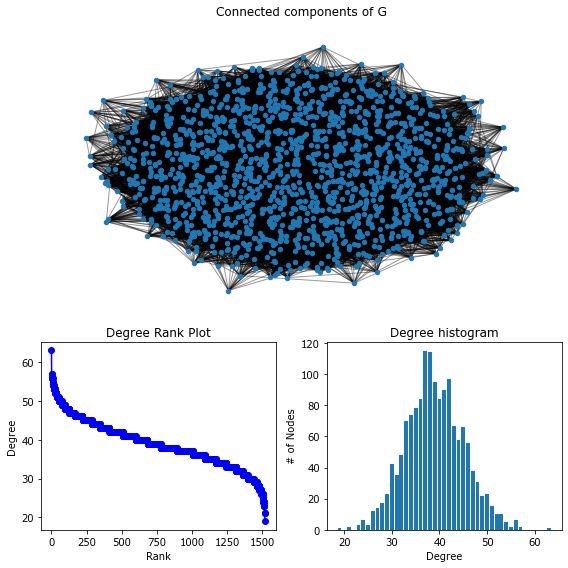

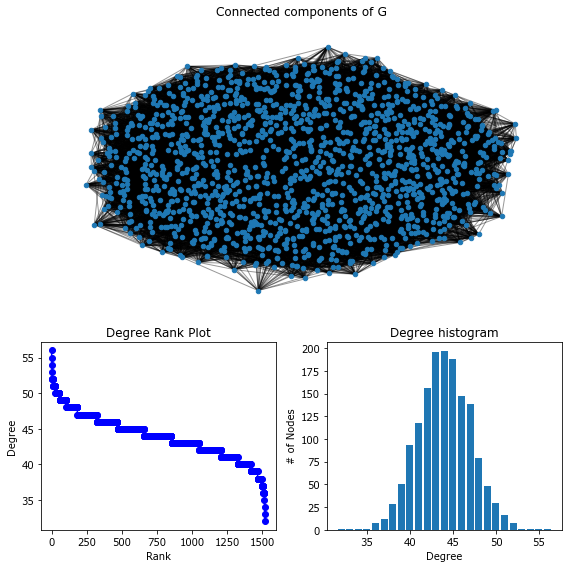

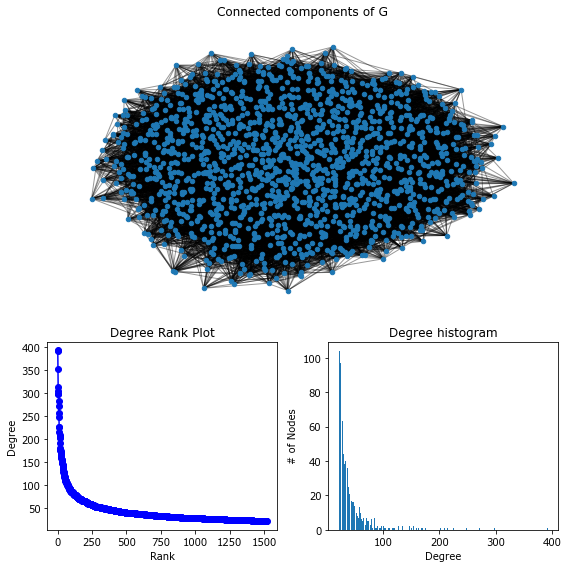

In [28]:
## erdos_renyi: 
## - creates all nodes, then creates edges by connecting the nodes based on probability (p)
## - might create unconnected graph
## - high probability -> high density
## 
## for p=0.5 the analysis took > 15m to complete and the graph was too dense
## use p=0.026
g_erdos_renyi_uncon = nx.erdos_renyi_graph(G.number_of_nodes(), p=0.026, directed=False, seed=11)
Gcc = sorted(nx.connected_components(g_erdos_renyi_uncon), key=len, reverse=True)
g_erdos_renyi = g_erdos_renyi_uncon.subgraph(Gcc[0])

## wattz_strogatz:
## - small-world property: the network has few "long-distance" links but there are short paths between most pairs of nodes (hubs)
g_watts_strogatz = nx.connected_watts_strogatz_graph(G.number_of_nodes(), k=44, p=0.25)

## power_law:
## - follows the 80/20 rule
g_powerlaw_cluster = nx.powerlaw_cluster_graph(G.number_of_nodes(), m=22, p=0.9)

do_comparison(
   [g_erdos_renyi, g_watts_strogatz, g_powerlaw_cluster],
   ["erdos_renyi", "wattz_strogatz", "powerlaw_cluster"])
do_analysis(g_erdos_renyi)
do_analysis(g_watts_strogatz)
do_analysis(g_powerlaw_cluster)

### Scenario B: Advanced Generators

Graphs generated using the Barabasi Albert approach.  

Graph #1 is a simple invocation of Barabasi Albert graph generator.  
Graph #2 uses as initial graph a star graph and extends it with the Barabasi Albert generator.  
Graph #3 is similar, using as base graph a windmill graph.  

METRICS                    barabasi_albert            star-barabasi_albert       windmill-barabasi_albert   
------------------------------------------------------------------------------------------------------------
Number of vertices         1519                       1519                       1519                       
Number of edges            32934                      33076                      33660                      
Max vertex degree          326                        1140                       337                        
Avg vertex degree          43.36273864384464          43.54970375246873          44.31863067807768          
Avg closeness centrality   0.4500868892576352         0.47806865067724313        0.4430282906062662         
Avg degree centrality      0.02856570398145236        0.028688869402153174       0.029195408878839067       
Radius                     2                          2                          2                          
Diameter           

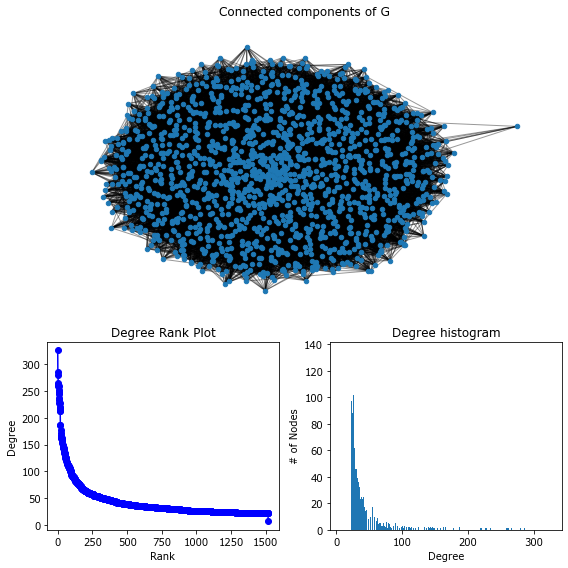

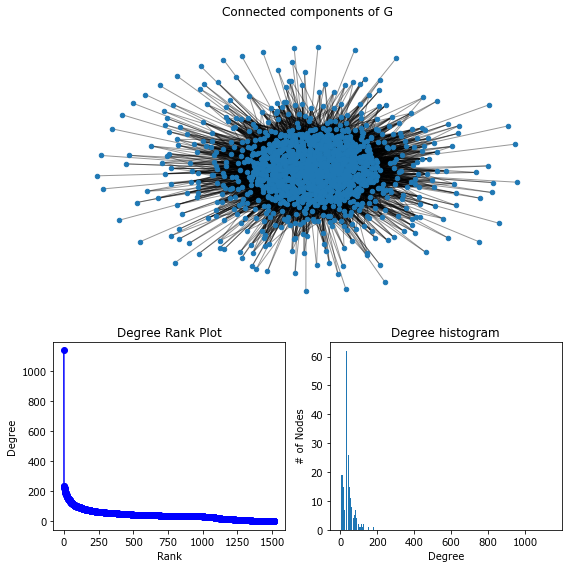

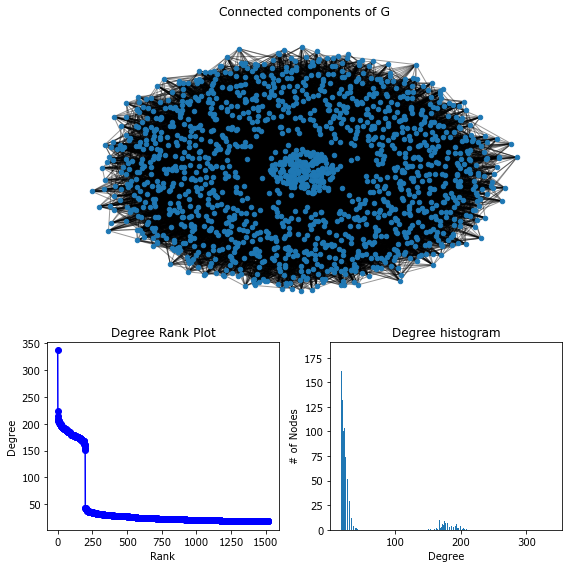

In [29]:
g_barabasi_albert = nx.barabasi_albert_graph(G.number_of_nodes(), 22)

g_star = nx.star_graph(500)
g_ba_star = nx.barabasi_albert_graph(G.number_of_nodes(), 32, initial_graph=g_star)

g_windmill = nx.windmill_graph(2, 100)
g_ba_windmill = nx.barabasi_albert_graph(G.number_of_nodes(), 18, initial_graph=g_windmill)

do_comparison(
   [g_barabasi_albert, g_ba_star, g_ba_windmill],
   ["barabasi_albert", "star-barabasi_albert", "windmill-barabasi_albert"])
   
do_analysis(g_barabasi_albert)
do_analysis(g_ba_star)
do_analysis(g_ba_windmill)

### Scenario C: Custom Generator

Studying carefully the extracted ego-graph we can notice that it is consisted of some hubs of nodes spread among the diameter, maintaining the power-law distribution. We could try to synthesize something close to the original by using a combination of windmill graphs. 

Windmill graphs generate hubs strongly connected, meaning the number of edges and triangles are high. To keep their number under control, we use a method to trim the edges among the nodes of each community by a custom probability.  
This way we can control the clustering coefficient as well as the graphs density and the number of edges and triangles.

To increase the maximum vertex degree we can add extra nodes to the node with the highest vertex degree.

To fill the remaining edges and complete the graph we pass the custom base graph to the Barabasi Albert generator.

METRICS                    synthetic_custom           
------------------------------------------------------
Number of vertices         1517                       
Number of edges            32222                      
Max vertex degree          1007                       
Avg vertex degree          42.48121292023731          
Avg closeness centrality   0.42321428864723093        
Avg degree centrality      0.028021908258732298       
Radius                     3                          
Diameter                   4                          
Avg clustering coefficient 0.3190182239453998         
Number of triangles        516390.0                   
Transitivity               0.5185171301067413         
Density                    0.028021908258731736       


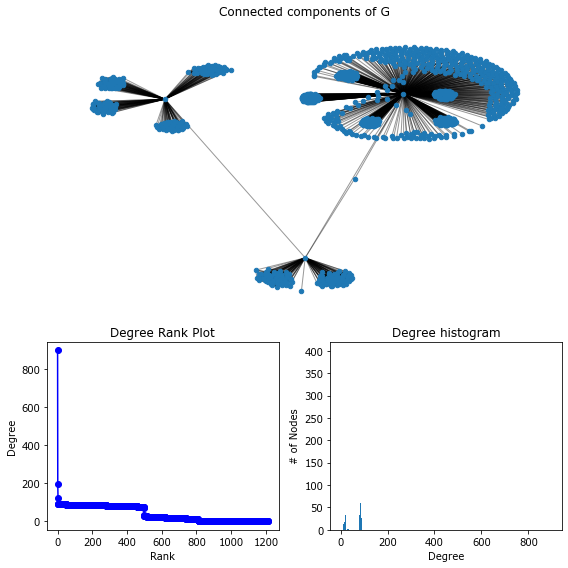

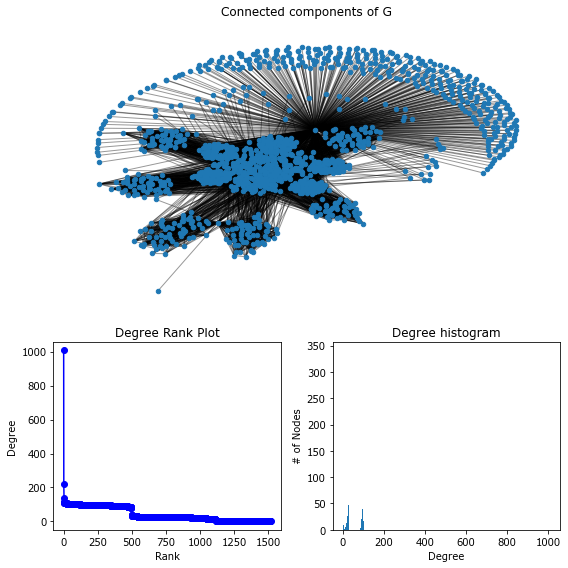

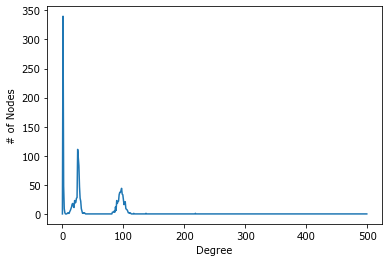

In [30]:
## feels like cheating
def trim_edges(G: Graph, p: int, center: int=0):
    edges_to_remove = []
    for n in G.nodes():
        if n == center: continue
        for e in G.edges(n):
            if e[0] != center and e[1] != center and random.randint(1, 100) > p:
                edges_to_remove.append(e)
    for e in edges_to_remove:
        if G.has_edge(e[0], e[1]):
            G.remove_edge(e[0], e[1])

g_base = nx.windmill_graph(4, 50)
trim_edges(g_base, 65, center=0)

g_base.add_node(200)
g_base.add_edge(0, 200)

g_base_2 = nx.windmill_graph(2, 60)
trim_edges(g_base_2, 50, center=0)
g_base_2.add_node(118)
g_base_2.add_edge(0, 118)
g_base_2.add_node(119)
g_base_2.add_edge(0, 119)
g_base_2.add_node(120)
g_base_2.add_edge(0, 120)
g_base_2 = nx.convert_node_labels_to_integers(g_base_2, first_label=200)

g_tmp = nx.compose(g_base, g_base_2)
g_tmp.add_edge(199, 200)

g_base_3 = nx.windmill_graph(5, 100)
trim_edges(g_base_3, 92, center=0)
g_base_3_len = len(g_base_3.nodes())-1
for i in range(g_base_3_len, g_base_3_len + 400):
    g_base_3.add_node(i)
    g_base_3.add_edge(0, i)
g_base_3 = nx.convert_node_labels_to_integers(g_base_3, first_label=320)

g_custom_base = nx.compose(g_tmp, g_base_3)
g_custom_base.add_edge(319, 320)

G_custom = nx.barabasi_albert_graph(G.number_of_nodes(), 25, initial_graph=g_custom_base);


do_comparison([G_custom], ["synthetic_custom"])
do_analysis(g_custom_base)
do_analysis(G_custom)

hist = nx.degree_histogram(G_custom)
plt.xlabel("Degree")
plt.ylabel("# of Nodes")
plt.plot(range(500), hist[:500]);

---

## Algorithms

### Link Prediction

At first we make predictions based on selecting random edges in the whole graph

In [32]:
def select_random_edges(edge_list, n):
    random_edges = []
    counter = 0
    edge_list_length = len(edge_list)
    while True:
        index = random.randint(0,edge_list_length)
        selected_edge = edge_list[index]
        if selected_edge in set(random_edges):
            continue
        random_edges.append(selected_edge)
        if counter == n:
            return random_edges
        counter += 1


def get_metrics(threshold, cn_similarity, random_edges, non_edge_cn_similarity, random_non_edges):
    true_positive = 0
    false_positive = 0
    for i in range(len(random_edges)):
        if cn_similarity[random_edges[i]] > threshold:
            true_positive += 1
        if non_edge_cn_similarity[random_non_edges[i]] > threshold:
            false_positive += 1
    false_negative = len(random_edges) - true_positive
    true_negative = len(random_non_edges) - false_negative
    tpr = true_positive / (false_negative + true_positive)
    fpr = false_positive / (false_positive + true_negative)
    return {'threshold':threshold},{'tpr':tpr},{'fpr':fpr}

#### Preparation

##### Facebook Ego-Graph

Mean similarity = 44.964113980409614
[({'threshold': 0.5}, {'tpr': 0.9985163204747775}, {'fpr': 0.3473622963537626}), ({'threshold': 1.0}, {'tpr': 0.9866468842729971}, {'fpr': 0.11920529801324503}), ({'threshold': 1.5}, {'tpr': 0.9866468842729971}, {'fpr': 0.11920529801324503}), ({'threshold': 2.0}, {'tpr': 0.9738872403560831}, {'fpr': 0.07912457912457913}), ({'threshold': 2.5}, {'tpr': 0.9738872403560831}, {'fpr': 0.07912457912457913}), ({'threshold': 3.0}, {'tpr': 0.9596439169139466}, {'fpr': 0.06477732793522267}), ({'threshold': 3.5}, {'tpr': 0.9596439169139466}, {'fpr': 0.06477732793522267}), ({'threshold': 4.0}, {'tpr': 0.9448071216617211}, {'fpr': 0.05547315336695342}), ({'threshold': 4.5}, {'tpr': 0.9448071216617211}, {'fpr': 0.05547315336695342}), ({'threshold': 5.0}, {'tpr': 0.93026706231454}, {'fpr': 0.0502877915783096}), ({'threshold': 5.5}, {'tpr': 0.93026706231454}, {'fpr': 0.0502877915783096}), ({'threshold': 6.0}, {'tpr': 0.9172106824925816}, {'fpr': 0.04569311515899969}

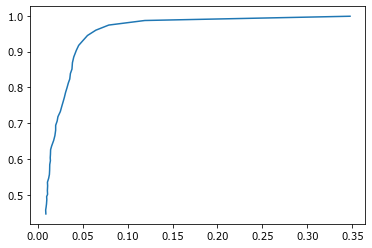

In [26]:
existing_edge_list = list(G.edges)
non_existing_edge_list = list(G_complement.edges)
existing_edge_list_length = len(existing_edge_list)
non_existing_edge_list_length = len(non_existing_edge_list)

n = int(0.1 * existing_edge_list_length)
random_edges = select_random_edges(existing_edge_list, n)
random_non_edges = select_random_edges(non_existing_edge_list, n)

cn_metrics = []
mean_similarity = mean(cn_similarity.values())
print("Mean similarity = {}".format(mean_similarity))
THRESHOLD_P = 0.5
t = THRESHOLD_P
while t < mean_similarity:
    cn_metrics.append(get_metrics(t, cn_similarity, random_edges, non_edge_cn_similarity, random_non_edges))
    t += THRESHOLD_P

print(cn_metrics)

auroc_x = []
aurox_y = []
for i in range(len(cn_metrics)):
    auroc_x.append(cn_metrics[i][2]['fpr'])
    aurox_y.append(cn_metrics[i][1]['tpr'])

plt.plot(auroc_x, aurox_y);

##### Synthetic Custom Graph

Mean similarity = 48.21063273813227
[({'threshold': 0.5}, {'tpr': 0.9576982892690513}, {'fpr': 0.3799838904550946}), ({'threshold': 1.0}, {'tpr': 0.929393468118196}, {'fpr': 0.16349384098544234}), ({'threshold': 1.5}, {'tpr': 0.929393468118196}, {'fpr': 0.16349384098544234}), ({'threshold': 2.0}, {'tpr': 0.8954898911353033}, {'fpr': 0.11578624078624078}), ({'threshold': 2.5}, {'tpr': 0.8954898911353033}, {'fpr': 0.11578624078624078}), ({'threshold': 3.0}, {'tpr': 0.8451010886469673}, {'fpr': 0.08733624454148471}), ({'threshold': 3.5}, {'tpr': 0.8451010886469673}, {'fpr': 0.08733624454148471}), ({'threshold': 4.0}, {'tpr': 0.7925349922239502}, {'fpr': 0.06323529411764706}), ({'threshold': 4.5}, {'tpr': 0.7925349922239502}, {'fpr': 0.06323529411764706}), ({'threshold': 5.0}, {'tpr': 0.7595645412130637}, {'fpr': 0.037445802128498226}), ({'threshold': 5.5}, {'tpr': 0.7595645412130637}, {'fpr': 0.037445802128498226}), ({'threshold': 6.0}, {'tpr': 0.7343701399688958}, {'fpr': 0.0223602484472

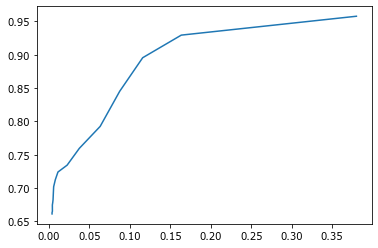

In [42]:
g_custom_complement = nx.complement(G_custom)
common_neighbors = {}
g_custom_cn_similarity = get_cn_similarity(G_custom), common_neighbors

non_edge_cn_similarity_custom = {}
for u, v in g_custom_complement.edges:
    non_edge_cn_similarity_custom[u, v] = len(list(nx.common_neighbors(G_custom, u, v)))

existing_edge_list = list(G_custom.edges)
non_existing_edge_list = list(g_custom_complement.edges)
existing_edge_list_length = len(existing_edge_list)
non_existing_edge_list_length = len(non_existing_edge_list)

n = int(0.1 * existing_edge_list_length)
random_edges = select_random_edges(existing_edge_list, n)
random_non_edges = select_random_edges(non_existing_edge_list, n)

cn_metrics = []
mean_similarity = mean(g_custom_cn_similarity.values())
print("Mean similarity = {}".format(mean_similarity))
THRESHOLD_P = 0.5
t = THRESHOLD_P
while t < mean_similarity:
    cn_metrics.append(get_metrics(t, g_custom_cn_similarity, random_edges, non_edge_cn_similarity_custom, random_non_edges))
    t += THRESHOLD_P

print(cn_metrics)

auroc_x = []
aurox_y = []
for i in range(len(cn_metrics)):
    auroc_x.append(cn_metrics[i][2]['fpr'])
    aurox_y.append(cn_metrics[i][1]['tpr'])

plt.plot(auroc_x, aurox_y);

#### Logistic Regression

##### Facebook Ego-Graph

In [34]:
data = {}
common_neighbors = {}
cn_similarity = get_cn_similarity(G, common_neighbors)
non_edge_cn_similarity = {}
G_complement = nx.complement(G)
for u, v in G_complement.edges:
    non_edge_cn_similarity[u, v] = len(list(nx.common_neighbors(G, u, v)))

for edge in cn_similarity:
    rai = nx.resource_allocation_index(G, [edge])
    ra_sim = list(rai)[0][2]
    data[cn_similarity[edge], ra_sim] = 1
    
for edge in non_edge_cn_similarity:
    rai = nx.resource_allocation_index(G, [edge])
    ra_sim = list(rai)[0][2]
    data[non_edge_cn_similarity[edge], ra_sim] = 0

X_data = [list(x) for x in list(data.keys())]
Y_data = list(data.values())

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=0)

log_regression = LogisticRegression()

log_regression.fit(X_train,y_train)

y_pred_proba = log_regression.predict_proba(X_test)[::,1]

auc = metrics.roc_auc_score(y_test, y_pred_proba)

print(auc)

0.8988456325279275


##### Synthetic Custom Graph

In [35]:
data = {}
common_neighbors = {}
cn_similarity = get_cn_similarity(G_custom, common_neighbors)
g_custom_complement = nx.complement(G_custom)
non_edge_cn_similarity = {}
for u, v in g_custom_complement.edges:
    non_edge_cn_similarity[u, v] = len(list(nx.common_neighbors(G_custom, u, v)))

for edge in cn_similarity:
    rai = nx.resource_allocation_index(G_custom, [edge])
    ra_sim = list(rai)[0][2]
    data[cn_similarity[edge], ra_sim] = 1
    
for edge in non_edge_cn_similarity:
    rai = nx.resource_allocation_index(G_custom, [edge])
    ra_sim = list(rai)[0][2]
    data[non_edge_cn_similarity[edge], ra_sim] = 0

X_data = [list(x) for x in list(data.keys())]
Y_data = list(data.values())

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=0)

log_regression = LogisticRegression()

log_regression.fit(X_train, y_train)

y_pred_proba = log_regression.predict_proba(X_test)[::,1]

auc = metrics.roc_auc_score(y_test, y_pred_proba)

print(auc)

0.9037687478240399


#### Jaccard Coefficient

##### Facebook Ego-Graph

In [10]:
scores = {}
scores_gen = nx.jaccard_coefficient(G)
for u, v, s in scores_gen:
    # print(f"({u}, {v}) -> {s:.8f}")
    scores[(u, v)] = s

print("Number of scores = {}".format(str(len(scores))))
print_min_max(scores, "Jaccard Coefficient score")

Number of scores = 1119231
Top max:
Jaccard Coefficient score of (11, 12) is 1.0
Jaccard Coefficient score of (11, 15) is 1.0
Jaccard Coefficient score of (11, 18) is 1.0
Jaccard Coefficient score of (11, 37) is 1.0
Jaccard Coefficient score of (11, 43) is 1.0
Jaccard Coefficient score of (11, 74) is 1.0
Jaccard Coefficient score of (11, 114) is 1.0
Jaccard Coefficient score of (11, 209) is 1.0
Jaccard Coefficient score of (11, 210) is 1.0
Jaccard Coefficient score of (11, 215) is 1.0
Top min:
Jaccard Coefficient score of (1, 348) is 0.0
Jaccard Coefficient score of (1, 351) is 0.0
Jaccard Coefficient score of (1, 353) is 0.0
Jaccard Coefficient score of (1, 363) is 0.0
Jaccard Coefficient score of (1, 364) is 0.0
Jaccard Coefficient score of (1, 366) is 0.0
Jaccard Coefficient score of (1, 376) is 0.0
Jaccard Coefficient score of (1, 389) is 0.0
Jaccard Coefficient score of (1, 393) is 0.0
Jaccard Coefficient score of (1, 399) is 0.0


##### Synthetic Custom Graph

In [36]:
scores = {}
scores_gen = nx.jaccard_coefficient(G_custom)
for u, v, s in scores_gen:
    # print(f"({u}, {v}) -> {s:.8f}")
    scores[(u, v)] = s

print("Number of scores = {}".format(str(len(scores))))
print_min_max(scores, "Jaccard Coefficient score")

Number of scores = 1117664
Top max:
Jaccard Coefficient score of (816, 817) is 1.0
Jaccard Coefficient score of (816, 818) is 1.0
Jaccard Coefficient score of (816, 819) is 1.0
Jaccard Coefficient score of (816, 820) is 1.0
Jaccard Coefficient score of (816, 821) is 1.0
Jaccard Coefficient score of (816, 822) is 1.0
Jaccard Coefficient score of (816, 823) is 1.0
Jaccard Coefficient score of (816, 824) is 1.0
Jaccard Coefficient score of (816, 825) is 1.0
Jaccard Coefficient score of (816, 826) is 1.0
Top min:
Jaccard Coefficient score of (0, 326) is 0.0
Jaccard Coefficient score of (0, 327) is 0.0
Jaccard Coefficient score of (0, 328) is 0.0
Jaccard Coefficient score of (0, 330) is 0.0
Jaccard Coefficient score of (0, 331) is 0.0
Jaccard Coefficient score of (0, 334) is 0.0
Jaccard Coefficient score of (0, 336) is 0.0
Jaccard Coefficient score of (0, 338) is 0.0
Jaccard Coefficient score of (0, 341) is 0.0
Jaccard Coefficient score of (0, 342) is 0.0


### Community Detection

#### Preparation

Due to the generally low betweenness centrality among the nodes of both the real and the ego-graph, the algorithms to detect communities could take too long to execute. That is why we will extract an even smaller sub-graph (`S`) with good amount of information to perform our tests.  

In [74]:
G_degree = {};
for node in G.nodes:
   count = 0;
   for edge in G.edges(node):
      count += 1;
   G_degree[node] = count;

print_min_max(get_graph_degrees(G), "Vertex Degree", 5)

Top max:
Vertex Degree of 107 is 1045
Vertex Degree of 0 is 347
Vertex Degree of 1888 is 254
Vertex Degree of 1800 is 245
Vertex Degree of 1663 is 235
Top min:
Vertex Degree of 11 is 1
Vertex Degree of 12 is 1
Vertex Degree of 15 is 1
Vertex Degree of 18 is 1
Vertex Degree of 37 is 1


Subgraph is connected? -> True
Number of vertices: 500
Number of edges: 3513
METRICS                    Graph #0                   
------------------------------------------------------
Number of vertices         500                        
Number of edges            3513                       
Max vertex degree          347                        
Avg vertex degree          14.052                     
Avg closeness centrality   0.4202641548547504         
Avg degree centrality      0.028160320641282512       
Radius                     2                          
Diameter                   3                          
Avg clustering coefficient 0.6506405789776873         
Number of triangles        14684.0                    
Transitivity               0.27800602056078305        
Density                    0.028160320641282564       


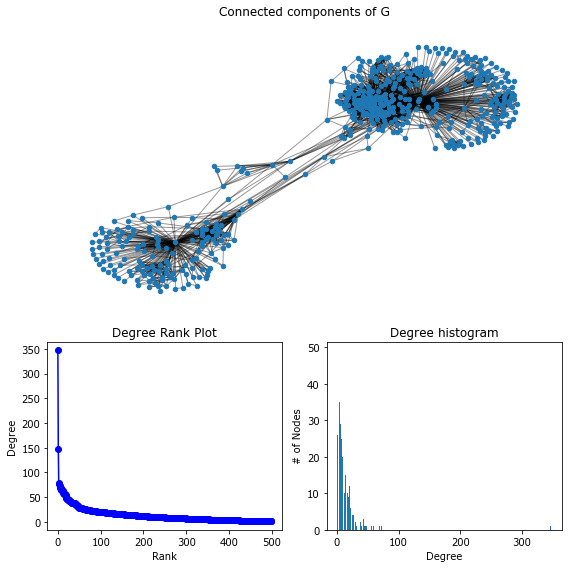

In [106]:
G_int = nx.convert_node_labels_to_integers(g_fb, first_label=0)
S = nx.subgraph(G_int, range(500))
print("Subgraph is connected? -> {}".format(str(nx.is_connected(S))))
print("Number of vertices: {}".format(S.number_of_nodes()))
print("Number of edges: {}".format(S.number_of_edges()))
do_comparison([S])
do_analysis(S)

In [75]:
g_custom_degree = {};
for node in G_custom.nodes:
   count = 0;
   for edge in G_custom.edges(node):
      count += 1;
   g_custom_degree[node] = count;

print_min_max(get_graph_degrees(G_custom), "Vertex Degree", 5)

Top max:
Vertex Degree of 320 is 1008
Vertex Degree of 0 is 215
Vertex Degree of 200 is 147
Vertex Degree of 722 is 112
Vertex Degree of 623 is 111
Top min:
Vertex Degree of 199 is 1
Vertex Degree of 816 is 1
Vertex Degree of 817 is 1
Vertex Degree of 818 is 1
Vertex Degree of 819 is 1


Subgraph is connected? -> True
Number of vertices: 148
Number of edges: 1039
METRICS                    Graph #0                   
------------------------------------------------------
Number of vertices         148                        
Number of edges            1039                       
Max vertex degree          147                        
Avg vertex degree          14.04054054054054          
Avg closeness centrality   0.5268435098411391         
Avg degree centrality      0.095513881228167          
Radius                     1                          
Diameter                   2                          
Avg clustering coefficient 0.3891575115936342         
Number of triangles        1883.0                     
Transitivity               0.22466592427616927        
Density                    0.09551388122816694        


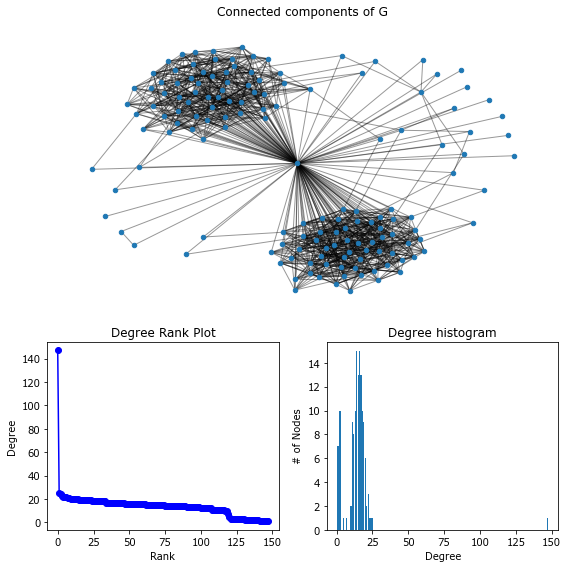

In [119]:
S_custom = nx.ego_graph(G_custom, 199, 2)
print("Subgraph is connected? -> {}".format(str(nx.is_connected(S_custom))))
print("Number of vertices: {}".format(S_custom.number_of_nodes()))
print("Number of edges: {}".format(S_custom.number_of_edges()))
do_comparison([S_custom])
do_analysis(S_custom)

## uncomment to use a subgraph instead of ego graph (comment the section above)
# g_int = nx.convert_node_labels_to_integers(G_custom, first_label=0)
# S_custom = nx.subgraph(g_int, range(300))
# print("Subgraph is connected? -> {}".format(str(nx.is_connected(S_custom))))
# print("Number of vertices: {}".format(S_custom.number_of_nodes()))
# print("Number of edges: {}".format(S_custom.number_of_edges()))
# do_comparison([S_custom])
# do_analysis(S_custom)

#### Spectral Clustering

In [96]:
def show_n_communities(g: Graph, n: int):
    colors = ['red', 'blue', 'yellow', 'green', 'pink', 'brown', 'orange', 'cyan', 'black', 'magenta']
    if n > len(colors) -  1 :
        print("Not enough colors for size {}".format(n))
        return
    g_target = copy.deepcopy(g)
    ## Create laplacian
    ## Laplacian = Degree - Adjacency
    # l = nx.number_of_nodes(g_target) + 1
    l = nx.number_of_nodes(g_target)
    A = np.zeros((l, l))

    for e in g_target.edges(): 
        s = e[0]
        t = e[1]
        A[s][t] = 1
        A[t][s] = 1

    # print("Adjacency matrix")
    # print(A)

    # Run spectral clustering using A as the affinity matrix. 
    from sklearn.cluster import SpectralClustering
    sc = SpectralClustering(n, affinity='precomputed', n_init=100,
                            assign_labels='discretize')
    clusters = sc.fit_predict(A)
    groups = []
    for i in range(n):
        group = np.where(clusters == i)[0]
        group = np.delete(group, np.where(group == 0))
        groups.append(group)

    positions = nx.spectral_layout(g_target, weight=None)
    vertex_labels={v: v for v in g_target.nodes()}
    for i in range(n):
        nx.draw_networkx_nodes( g_target, 
                                pos=positions, 
                                nodelist=groups[i], 
                                node_color=colors[i], 
                                label=vertex_labels,
                                node_size=80.0)
        print("Group #{} ({}) has {} nodes".format(i+1, colors[i], len(groups[i])))
    
    for i in range(n):
        print("---------------------------------------------")
        print("Nodes of group #{} ({}): {}".format(i+1, colors[i], groups[i]))

    nx.draw_networkx_edges( g_target, 
                            pos=positions, 
                            width=0.5)

    plt.show()

Group #1 (red) has 457 nodes
Group #2 (blue) has 1061 nodes
---------------------------------------------
Nodes of group #1 (red): [   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   22   23   24   25   26   27   28
   29   30   31   32   33   34   35   36   37   38   39   40   41   42
   43   44   45   46   47   48   49   50   51   52   53   54   55   56
   57   58   59   60   61   62   63   64   65   66   67   68   69   70
   71   72   73   74   75   76   77   78   79   80   81   82   83   84
   85   86   87   88   89   90   91   92   93   94   95   96   97   98
   99  100  101  102  103  104  105  106  108  109  110  111  112  113
  114  115  116  117  118  119  120  121  122  123  124  125  126  127
  128  129  130  131  132  133  134  135  136  137  138  139  140  141
  142  143  144  145  146  147  148  149  150  151  152  153  154  155
  156  157  158  159  160  161  162  163  164  165  166  167  168  169
  170  171  172  

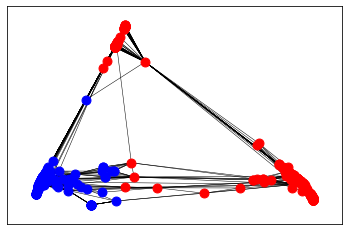

In [98]:
## facebook ego-graph G
g_in = nx.convert_node_labels_to_integers(G, first_label=0)
show_n_communities(g_in, 2)

Group #1 (red) has 1062 nodes
Group #2 (blue) has 114 nodes
Group #3 (yellow) has 342 nodes
---------------------------------------------
Nodes of group #1 (red): [  34   58  107 ... 1516 1517 1518]
---------------------------------------------
Nodes of group #2 (blue): [ 136  954 1066 1207 1401 1402 1403 1404 1405 1406 1407 1408 1409 1410
 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420 1421 1422 1423 1424
 1425 1426 1427 1428 1429 1430 1431 1432 1433 1434 1435 1436 1437 1438
 1439 1440 1441 1442 1443 1444 1445 1446 1447 1448 1449 1450 1451 1452
 1453 1454 1455 1456 1457 1458 1459 1460 1461 1462 1463 1464 1465 1466
 1467 1468 1469 1470 1471 1472 1473 1474 1475 1476 1477 1478 1479 1480
 1481 1482 1483 1484 1485 1486 1487 1488 1489 1490 1491 1492 1493 1494
 1495 1496 1497 1498 1499 1500 1501 1502 1503 1504 1505 1506 1507 1508
 1509 1510]
---------------------------------------------
Nodes of group #3 (yellow): [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  

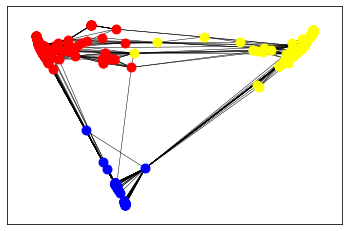

In [99]:
## facebook ego-graph G
g_in = nx.convert_node_labels_to_integers(G, first_label=0)
show_n_communities(g_in, 3)

Group #1 (red) has 1320 nodes
Group #2 (blue) has 196 nodes
---------------------------------------------
Nodes of group #1 (red): [ 197  198  199 ... 1514 1515 1516]
---------------------------------------------
Nodes of group #2 (blue): [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 18

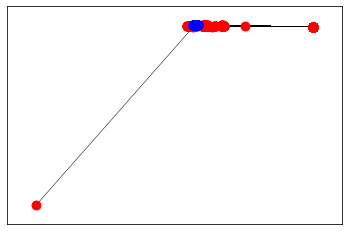

In [100]:
## synthetic custom graph
g_in = nx.convert_node_labels_to_integers(G_custom, first_label=0)

show_n_communities(g_in, 2)

Group #1 (red) has 1199 nodes
Group #2 (blue) has 121 nodes
Group #3 (yellow) has 196 nodes
---------------------------------------------
Nodes of group #1 (red): [ 317  319  320 ... 1514 1515 1516]
---------------------------------------------
Nodes of group #2 (blue): [197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250
 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268
 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286
 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304
 305 306 307 308 309 310 311 312 313 314 315 316 318]
---------------------------------------------
Nodes of group #3 (yellow): [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40 

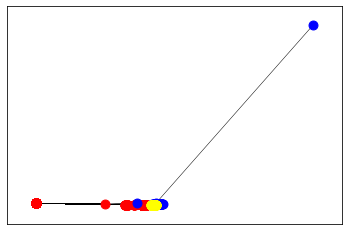

In [101]:
## synthetic custom graph
g_in = nx.convert_node_labels_to_integers(G_custom, first_label=0)

show_n_communities(g_in, 3)

#### Girvan-Newman

In [120]:
## Girvan-Newman
## works with edge betweenness centrality
## edge betweenness centrality -> the number of the shortest paths that go through an edge in a graph
def show_n_communities_gn(g: Graph, n: int, cc: int=6, cc_list: list=[]):
    colors = ['red', 'blue', 'yellow', 'green', 'pink', 'brown', 'orange', 'cyan', 'black', 'magenta']
    if n > len(colors) -  1 :
        print("Not enough colors for size {}".format(n))
        return
    g_target = copy.deepcopy(g)

    if len(cc_list) == 0:

        while nx.algorithms.components.number_connected_components(g_target) < cc:
            ec = nx.algorithms.centrality.edge_betweenness_centrality(g_target)
            max_edge = None
            max_value = None 
            for e, centrality in ec.items():
                if max_value is None or centrality > max_value: 
                    max_value = centrality
                    max_edge = e
            print("Deleting edge {} with centrality {}, connected components={}".format(
                max_edge, max_value, nx.algorithms.components.number_connected_components(g_target)))
            g_target.remove_edge(*max_edge)

        cc_list = list(nx.connected_components(g_target))

    ccs = cc_list
    num_components = len(ccs)
    groups = []
    for i in range(n):
        groups.append(ccs[i])

    positions = nx.spring_layout(g_target) # spring layout -> "fruchterman_reingold"
    for i in range(n):
        nx.draw_networkx_nodes( g_target, pos=positions, 
                                nodelist=groups[i], 
                                node_color=colors[i],
                                node_size=80)
        print("Group #{} ({}) has {} nodes".format(i+1, colors[i], len(groups[i])))
    nx.draw_networkx_edges( g_target, 
                            pos=positions, 
                            width=0.5)
    
    for i in range(n):
        print("---------------------------------------------")
        print("Nodes of group #{} ({}): {}".format(i+1, colors[i], groups[i]))

    plt.show()
    return ccs;

##### Facebook subgraph

In [ ]:
## Extracting the list of connected components to use them as input and speed up the computation
## WARNING: kinda slow (~1m15s)
S_cc = show_n_communities_gn(nx.Graph(S), n=1, cc=5)

Group #1 (red) has 338 nodes
Group #2 (blue) has 148 nodes
---------------------------------------------
Nodes of group #1 (red): {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 172, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 203, 2

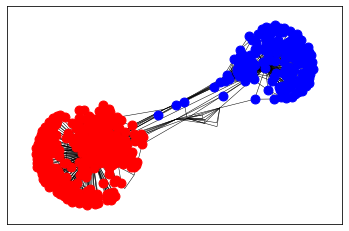

In [125]:
## facebook subgraph S: 2 communities
_ = show_n_communities_gn(nx.Graph(S), n=2, cc_list=S_cc)

Group #1 (red) has 338 nodes
Group #2 (blue) has 148 nodes
Group #3 (yellow) has 9 nodes
---------------------------------------------
Nodes of group #1 (red): {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 172, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 1

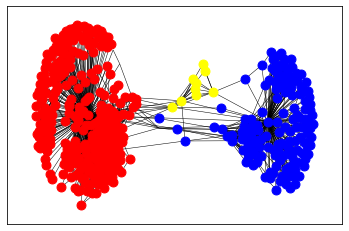

In [126]:
## facebook subgraph S
_ = show_n_communities_gn(nx.Graph(S), n=3, cc_list=S_cc)

##### Custom subgraph

Deleting edge (199, 200) with centrality 0.013513513513513514, connected components=1
Deleting edge (200, 1256) with centrality 0.013421584850156279, connected components=2
Deleting edge (200, 1329) with centrality 0.013329656186799044, connected components=3
Deleting edge (200, 1401) with centrality 0.01323772752344181, connected components=4
Group #1 (red) has 144 nodes
---------------------------------------------
Nodes of group #1 (red): {0, 254, 253, 248, 1216, 252, 200, 201, 202, 203, 204, 1229, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 1241, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 1255, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 1267, 240, 241, 242, 247, 243, 249, 250, 251, 244, 245, 246, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 1324, 300, 301, 302,

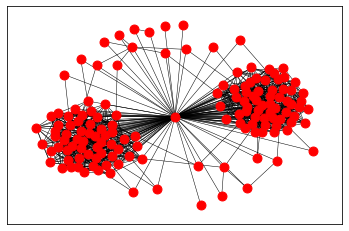

In [128]:
## Extracting the list of connected components to use them as input and speed up the computation
S_custom_cc = show_n_communities_gn(nx.Graph(S_custom), n=1, cc=5)

Group #1 (red) has 144 nodes
Group #2 (blue) has 1 nodes
---------------------------------------------
Nodes of group #1 (red): {0, 254, 253, 248, 1216, 252, 200, 201, 202, 203, 204, 1229, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 1241, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 1255, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 1267, 240, 241, 242, 247, 243, 249, 250, 251, 244, 245, 246, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 1324, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 1342, 1285, 1350, 1354, 1371, 1391, 1273, 1299, 1431, 1437, 1447, 1459, 1497, 1499, 1505, 1506}
---------------------------------------------
Nodes of group #2 (blue): {199}


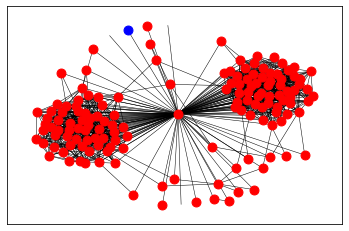

In [129]:
## custom subgraph s: 2 communities
_ = show_n_communities_gn(nx.Graph(S_custom), n=2, cc_list=S_custom_cc)

Group #1 (red) has 144 nodes
Group #2 (blue) has 1 nodes
Group #3 (yellow) has 1 nodes
Group #4 (green) has 1 nodes
Group #5 (pink) has 1 nodes
---------------------------------------------
Nodes of group #1 (red): {0, 254, 253, 248, 1216, 252, 200, 201, 202, 203, 204, 1229, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 1241, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 1255, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 1267, 240, 241, 242, 247, 243, 249, 250, 251, 244, 245, 246, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 1324, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 1342, 1285, 1350, 1354, 1371, 1391, 1273, 1299, 1431, 1437, 1447, 1459, 1497, 1499, 1505, 1506}
--------------------------------------------

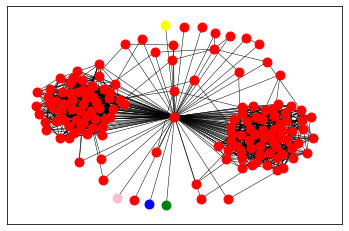

In [130]:
## custom subgraph s: 5 communities
_ = show_n_communities_gn(nx.Graph(S_custom), n=5, cc_list=S_custom_cc)

---

## Influence Maximization

We will define some helper functions for automating the simulations.

In [40]:
def do_simulation(model: DiffusionModel, iteration_bunch: int):
    ## Simulation execution
    iterations = model.iteration_bunch(iteration_bunch)
    trends = model.build_trends(iterations)
    viz = DiffusionTrend(model, trends)
    viz.plot()

def get_n_seeds(all_nodes: List, n: int):
    seeds = [];
    for _ in range(n):
        c = choice(all_nodes)
        seeds.append(c)
        all_nodes.remove(c)
    return seeds

### Threshold

When using the Threshold model on ego-facebook graph with random seeds we notice that the influence in the graph is almost zero. This happens because almost all nodes have zero degree except from few with very high degree.

However, when selecting the seeds based on the PageRank (nodes with highest degree) then the influence progresses quickly.

Selected random seeds: [242, 1069, 1680, 1504, 83, 1396, 1465, 1466, 2267, 1858, 117, 231, 1338, 1236, 1681, 260, 248, 1485, 1816, 1813, 60, 1366, 143, 233, 1826, 1294, 1079, 1548, 5, 1854, 2138, 1197, 1903, 192, 973, 173, 172, 1077, 2032, 1346, 2153, 1797, 1010, 157, 1662, 1463, 3173, 141, 153, 1505, 1474, 213, 2498, 1102, 1668, 92, 78, 1706, 1402, 23, 1205, 2508, 1565, 1155, 1733, 1425, 1536, 641, 1575, 126, 538, 2538, 128, 1130, 152, 1231, 1793, 29, 2740, 1327, 1765, 1972, 2814, 149, 923, 1357, 1247, 1577, 376, 955, 906, 1477, 1516, 1865, 1071, 1116, 13, 1932, 229, 1211]


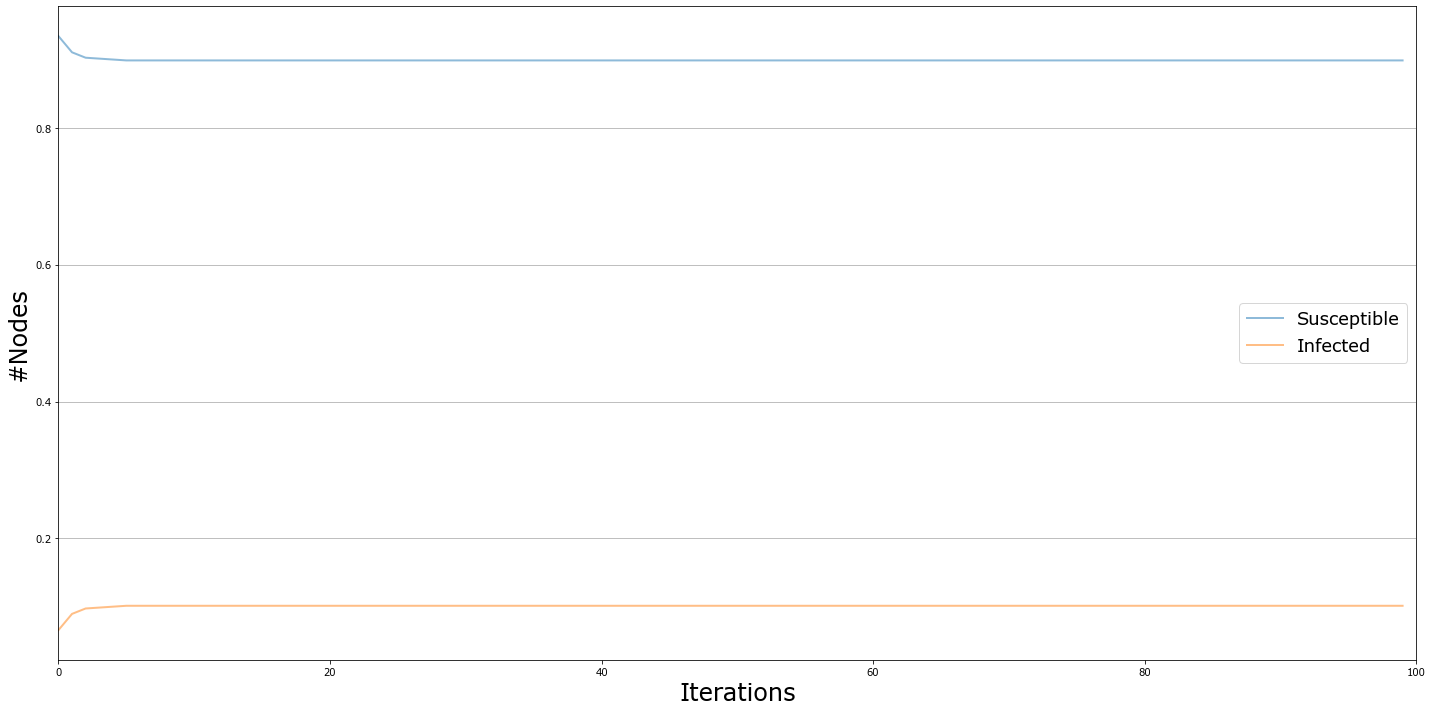

In [134]:
g_target = G
seeds = get_n_seeds(list(g_target.nodes()), 100)
# pr = nx.pagerank(G)
# seeds = [k for k, v in sorted(pr.items(), key=lambda item: item[1], reverse=True)][0:3]
print("Selected random seeds: {}".format(seeds))

model = ep.ThresholdModel(g_target)
config = mc.Configuration()
config.add_model_initial_configuration('Infected', seeds)
threshold = 0.25
for i in g_target.nodes():
    config.add_node_configuration("threshold", i, threshold)
model.set_initial_status(config)

do_simulation(model, iteration_bunch=100)

Selected highest PageRank seeds: [107, 0, 483, 56, 25, 322, 136, 67, 271, 119, 917, 1888, 277, 1800, 26, 21, 1352, 1663, 252, 1730, 1431, 1086, 122, 1783, 1584, 239, 1768, 1199, 315, 203, 9, 1827, 200, 1472, 896, 1912, 304, 1589, 1126, 1746, 1277, 1377, 1835]


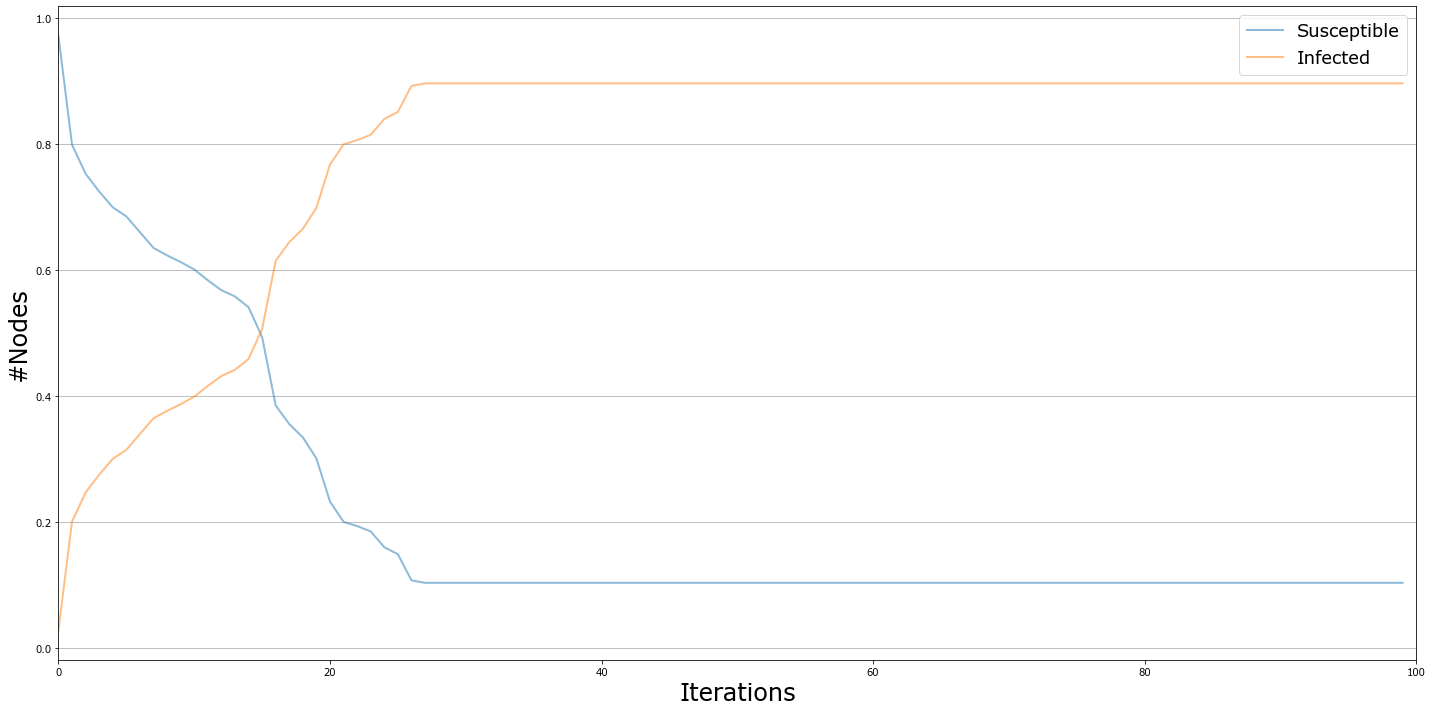

In [137]:
g_target = G
pr = nx.pagerank(g_target)
seeds = [k for k, v in sorted(pr.items(), key=lambda item: item[1], reverse=True)][0:43]
print("Selected highest PageRank seeds: {}".format(seeds))

model = ep.ThresholdModel(g_target)
config = mc.Configuration()
config.add_model_initial_configuration('Infected', seeds)
threshold = 0.25
for i in g_target.nodes():
    config.add_node_configuration("threshold", i, threshold)
model.set_initial_status(config)

do_simulation(model, iteration_bunch=100)

### Independent Cascades

As explained before, there is no point on choosing the k-seeds in random. We will select the nodes with the highest PageRank.

We will use this model to run our simulations.

In [38]:
THRESHOLD_IC = 0.4;

Selecting highest PageRank seeds=[107, 0, 483, 56, 25, 322, 136, 67, 271, 119, 917, 1888, 277, 1800, 26, 21, 1352, 1663, 252, 1730]


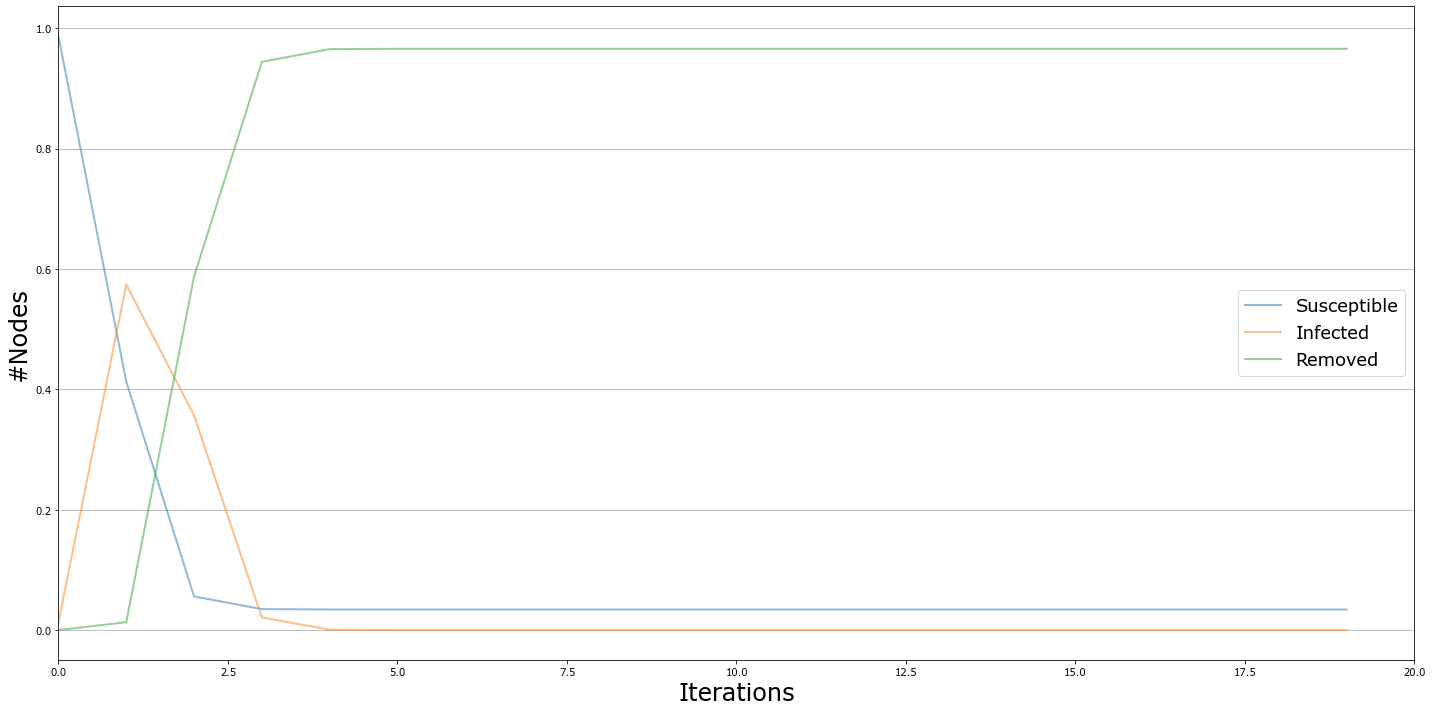

In [41]:
pr = nx.pagerank(G)
seeds = [k for k, v in sorted(pr.items(), key=lambda item: item[1], reverse=True)][0:20]
print("Selecting highest PageRank seeds={}".format(seeds))

model = ep.IndependentCascadesModel(G)
config = mc.Configuration()
config.add_model_initial_configuration('Infected', seeds)
threshold = THRESHOLD_IC
for e in G.edges():
    config.add_edge_configuration("threshold", e, threshold)
model.set_initial_status(config)

do_simulation(model, 20)

#### Finding Best k-seeds

In [160]:
def get_maximum_influence_across_iterations(model):
    iterations = model.iteration_bunch(100)
    max_inf = 0
    for i in iterations:
        if i.get('node_count').get(1) > max_inf:
            max_inf = i.get('node_count').get(1)
    return max_inf


def get_best_candidate(g: Graph, model, seeds, candidates):
    all_max_inf=[]
    for n in candidates:
        temp_seeds = []
        temp_seeds.append(x for x in seeds)
        temp_seeds.append(n)
        model = ep.IndependentCascadesModel(g)
        config = mc.Configuration()
        threshold = THRESHOLD_IC
        for i in g.nodes():
            config.add_node_configuration("threshold", i, threshold)
        config.add_model_initial_configuration("Infected", temp_seeds)
        model.set_initial_status(config) 
        max_inf = get_maximum_influence_across_iterations(model)
        all_max_inf.append(max_inf)
    print(np.asarray(all_max_inf).max())
    return candidates[np.asarray(all_max_inf).argmax()] 


## greedy approach
def get_n_best_seeds_greedy(g: Graph, n: int=50):
    model = ep.IndependentCascadesModel(g)
    config = mc.Configuration()
    threshold = THRESHOLD_IC
    all_nodes = []
    for i in g.nodes():
        config.add_node_configuration("threshold", i, threshold)
        all_nodes.append(i)

    best_seeds = []
    k = 50
    for _ in range(k):
        # candidates = list(all_nodes - best_seeds)
        candidates = [n for n in all_nodes if n not in best_seeds]
        next_best = get_best_candidate(g, model, best_seeds, candidates)
        best_seeds.append(next_best)
    return best_seeds

In [184]:
## facebook ego-graph G
## WARNING: slow (~107m)
G_best_seeds = get_n_best_seeds_greedy(G, n=50)
print("Best seeds for facebook ego-graph with t=0.4: \n{}".format(G_best_seeds))

468
453
463
478
493
472
462
475
468
464
457
468
496
467
457
458
449
459
480
448
467
486
460
462
454
497
485
478
453
469
452
459
454
459
474
466
466
464
479
460
478
453
449
490
458
469
465
465
448
449
Best seeds for facebook ego-graph with t=0.4: 
[2183, 2279, 163, 1136, 2660, 1025, 2254, 2001, 2471, 68, 2463, 2538, 205, 2543, 2640, 1052, 1011, 2649, 2589, 246, 2494, 2319, 1684, 1633, 2498, 2445, 2378, 188, 122, 1465, 24, 187, 2529, 1912, 2511, 2187, 177, 1995, 994, 269, 2491, 2268, 1945, 2018, 1062, 1630, 1183, 1606, 2417, 2436]


In [161]:
## facebook subgraph S
## WARNING: slow (~15m)
S_best_seeds = get_n_best_seeds_greedy(S, n=50)
print("Best seeds for facebook subgraph with t=0.4: \n{}".format(S_best_seeds))

84
90
84
85
84
92
89
83
86
84
82
90
84
78
80
87
85
89
87
87
84
86
87
95
87
84
86
82
88
82
88
87
86
92
85
84
82
86
86
83
85
85
86
86
86
84
86
81
85
82


In [165]:
## synthetic subgraph S_custom
S_custom_best_seeds = get_n_best_seeds_greedy(S_custom, n=50);
print("Best seeds for synthetic subgraph S_custom with t=0.4: \n{}".format(S_custom_best_seeds))

29
29
29
38
28
28
28
28
28
30
28
31
28
28
30
27
30
30
34
30
28
33
35
35
29
30
28
31
29
29
29
29
30
27
27
29
31
29
27
29
30
29
30
30
25
28
30
28
31
28
Best seeds for synthetic subgraph with t=0.4: 
[241, 300, 266, 228, 248, 301, 222, 288, 212, 205, 229, 230, 253, 267, 243, 280, 1506, 287, 226, 254, 233, 291, 276, 238, 204, 294, 210, 252, 277, 256, 207, 255, 258, 1285, 217, 216, 257, 240, 200, 263, 234, 272, 274, 237, 225, 236, 242, 259, 299, 270]


#### Running Simulations

##### Facebook Graph

Due to the graphs having distinct connection hubs with one-to-many connections, the only way to make the infection spread faster is to infect the nodes with the highest degree in those connection hubs. However, because most of the times the other nodes are connected only to those base-nodes, they cannot affect others when infected. This means that the infection stops from spreading further.

It seems that the only parameter that affects the infection outcome is each node's threshold. 

Selected seeds=[0, 107, 56, 25, 322, 67, 366, 119, 271, 277, 21, 26, 252, 122, 239, 315, 203, 9, 200, 304, 403, 285, 188, 170, 98, 272, 199, 40, 312, 376, 280, 359, 332, 186, 378, 432, 367, 213, 142, 350, 41, 172, 361, 349, 323, 348, 402, 382, 169, 113]


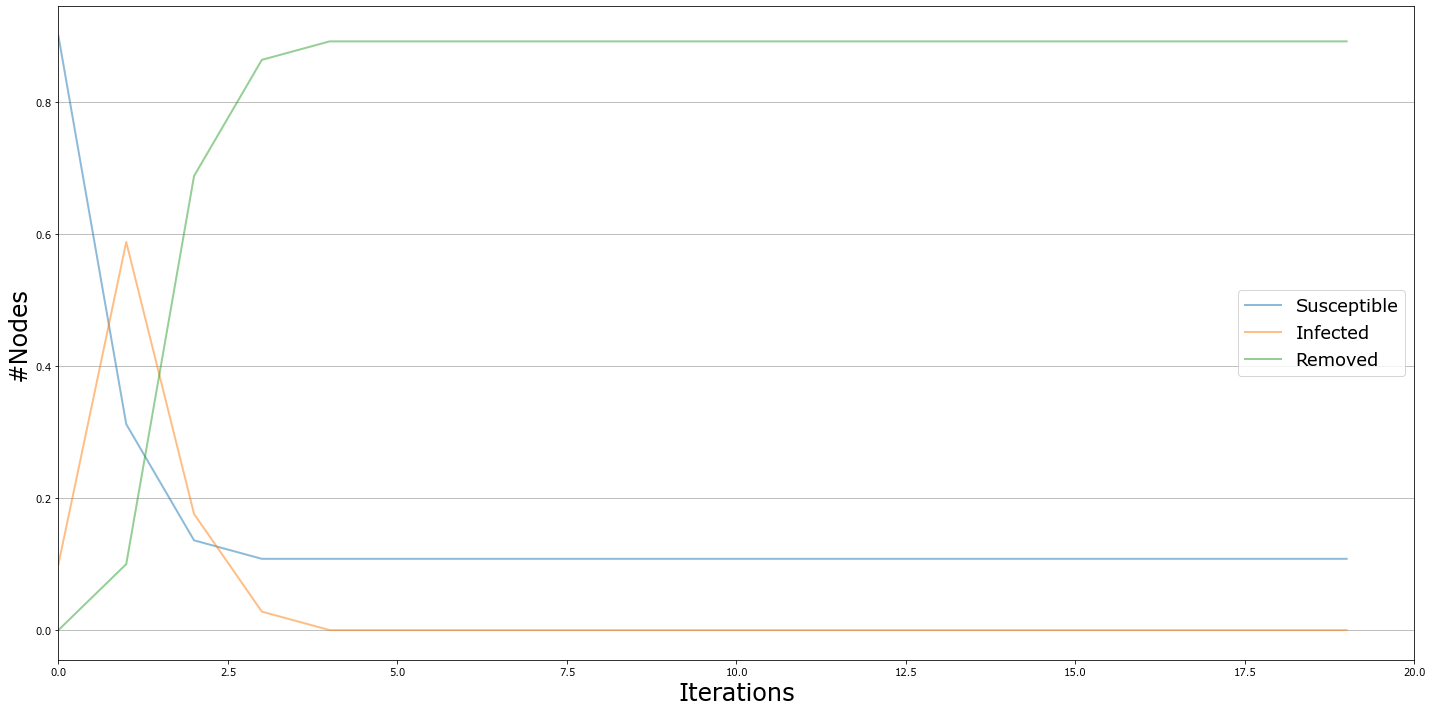

In [183]:
g_sim = S
pr_seeds = nx.pagerank(g_sim)

seeds = [k for k, v in sorted(pr_seeds.items(), key=lambda item: item[1], reverse=True)][0:50]
# seeds = S_best_seeds[0:50] 
print("Selected seeds={}".format(seeds))

model = ep.IndependentCascadesModel(g_sim)
config = mc.Configuration()
config.add_model_initial_configuration('Infected', seeds)

threshold = THRESHOLD_IC
for e in g_sim.edges():
    config.add_edge_configuration("threshold", e, threshold)
model.set_initial_status(config)

do_simulation(model, 20)

##### Synthetic Graph


Selected seeds=[200, 204, 296, 289, 237, 203, 225, 270, 294, 285, 205, 250, 258, 227, 252, 266, 230, 209, 244, 221, 269, 276, 290, 231, 304, 236, 259, 242, 257, 212, 273, 308, 262, 220, 291, 248, 313, 312, 217, 241, 214, 201, 315, 249, 278, 303, 268, 275, 251, 264]


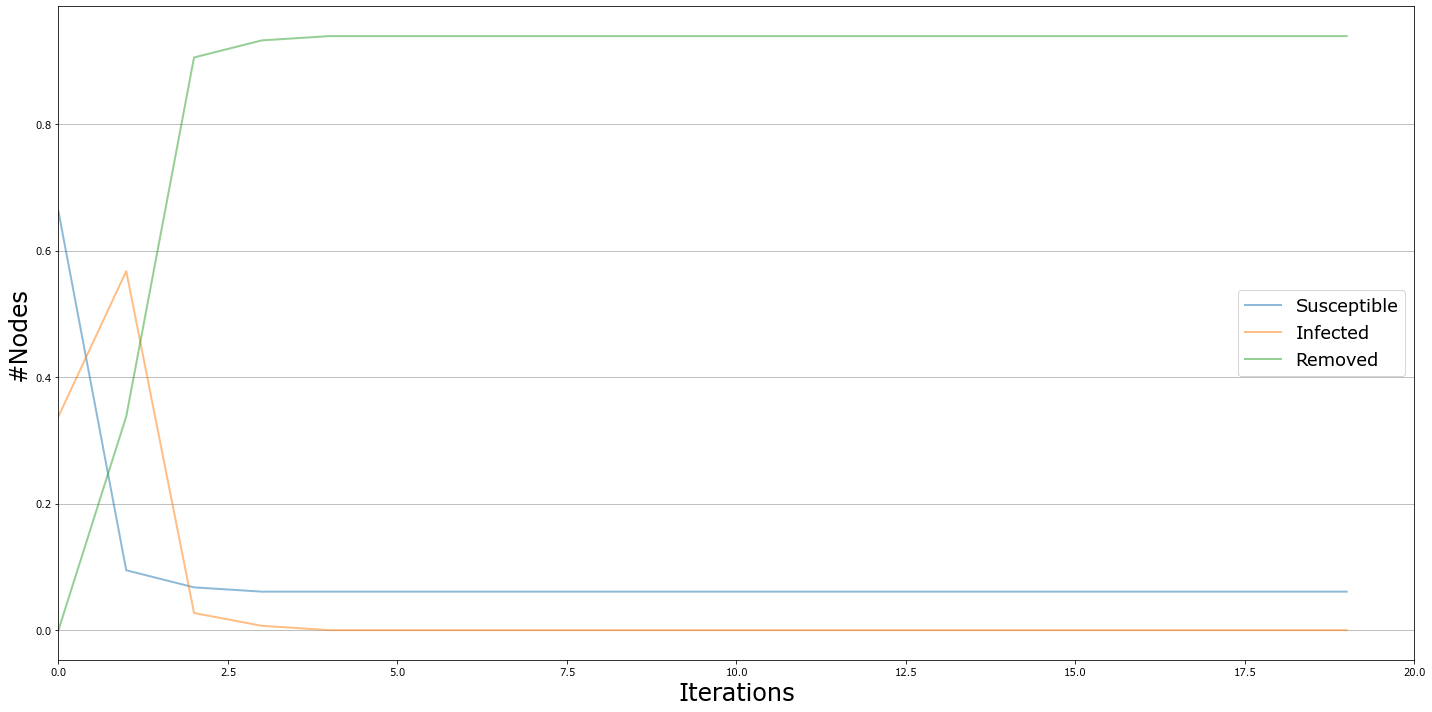

In [177]:
g_synth = S_custom

pr = nx.pagerank(g_synth)
seeds = [k for k, v in sorted(pr.items(), key=lambda item: item[1], reverse=True)][0:50]
# seeds = best_seeds[0:50] 
print("Selected seeds={}".format(seeds))

model = ep.IndependentCascadesModel(g_synth)
config = mc.Configuration()
config.add_model_initial_configuration('Infected', seeds)

threshold = THRESHOLD_IC
for e in g_synth.edges():
    config.add_edge_configuration("threshold", e, threshold)
model.set_initial_status(config)

do_simulation(model, 20)